# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-random'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'HS': [y_train[i][0] for i in temp],
            'Abusive': [y_train[i][1] for i in temp],
            'HS_Individual': [y_train[i][2] for i in temp],
            'HS_Group': [y_train[i][3] for i in temp],
            'HS_Religion': [y_train[i][4] for i in temp],
            'HS_Race': [y_train[i][5] for i in temp],
            'HS_Physical': [y_train[i][6] for i in temp],
            'HS_Gender': [y_train[i][7] for i in temp],
            'HS_Other': [y_train[i][8] for i in temp],
            'HS_Weak': [y_train[i][9] for i in temp],
            'HS_Moderate': [y_train[i][10] for i in temp],
            'HS_Strong': [y_train[i][11] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6046, Accuracy: 0.8193, F1 Micro: 0.1306, F1 Macro: 0.0476
Epoch 2/10, Train Loss: 0.4611, Accuracy: 0.8278, F1 Micro: 0.0018, F1 Macro: 0.0007
Epoch 3/10, Train Loss: 0.395, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3942, Accuracy: 0.828, F1 Micro: 0.0029, F1 Macro: 0.0013
Epoch 5/10, Train Loss: 0.3771, Accuracy: 0.8331, F1 Micro: 0.0672, F1 Macro: 0.0277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3693, Accuracy: 0.8492, F1 Micro: 0.2596, F1 Macro: 0.0906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3465, Accuracy: 0.8548, F1 Micro: 0.3235, F1 Macro: 0.1092
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3297, Accuracy: 0.8708, F1 Micro: 0.4854, F1 Macro: 0.2134
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2965, Accuracy: 0.8761, F1 Micro: 0.5481, F1 Macro: 0.2668
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2714, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.829, F1 Micro: 0.0196, F1 Macro: 0.0076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4, Accuracy: 0.8336, F1 Micro: 0.0745, F1 Macro: 0.0301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3712, Accuracy: 0.8568, F1 Micro: 0.3612, F1 Macro: 0.1167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3399, Accuracy: 0.8732, F1 Micro: 0.496, F1 Macro: 0.2266
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3007, Accuracy: 0.8811, F1 Micro: 0.5979, F1 Macro: 0.2934
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2675, Accuracy: 0.8859, F1 Micro: 0.6164, F1 Macro: 0.3444
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2398, Accuracy: 0.8907, F1 Micro: 0.6409, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2186, Accuracy: 0.8934, F1 Micro: 0.6665, F1 Macro: 0.4706
Epoch 9/10, Train Loss: 0.192, Accuracy: 0.8925, F1 Micro: 0.65

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4894, Accuracy: 0.829, F1 Micro: 0.0161, F1 Macro: 0.0064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3803, Accuracy: 0.855, F1 Micro: 0.3648, F1 Macro: 0.1139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.333, Accuracy: 0.8784, F1 Micro: 0.6141, F1 Macro: 0.2963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2912, Accuracy: 0.8886, F1 Micro: 0.6264, F1 Macro: 0.3204
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2501, Accuracy: 0.8951, F1 Micro: 0.6733, F1 Macro: 0.4115
Epoch 6/10, Train Loss: 0.2299, Accuracy: 0.8964, F1 Micro: 0.6517, F1 Macro: 0.4117
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1945, Accuracy: 0.8997, F1 Micro: 0.6866, F1 Macro: 0.466
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.172, Accuracy: 0.9019, F1 Micro: 0.6925, F1 Macro: 0.526
Epoch 9/10, Train Loss: 0.1567, Accuracy: 0.9011, F1 Micro: 0.6909, F1 Macro: 0.5111
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4636, Accuracy: 0.8331, F1 Micro: 0.0714, F1 Macro: 0.028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3588, Accuracy: 0.8769, F1 Micro: 0.5992, F1 Macro: 0.2776
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.303, Accuracy: 0.8877, F1 Micro: 0.6121, F1 Macro: 0.3152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2549, Accuracy: 0.8973, F1 Micro: 0.6767, F1 Macro: 0.4251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2146, Accuracy: 0.9022, F1 Micro: 0.688, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1863, Accuracy: 0.9038, F1 Micro: 0.7122, F1 Macro: 0.508
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1563, Accuracy: 0.9066, F1 Micro: 0.7183, F1 Macro: 0.5323
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1385, Accuracy: 0.9069, F1 Micro: 0.7184, F1 Macro: 0.5664
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4514, Accuracy: 0.8371, F1 Micro: 0.1223, F1 Macro: 0.0456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3384, Accuracy: 0.8822, F1 Micro: 0.6088, F1 Macro: 0.2979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2797, Accuracy: 0.8947, F1 Micro: 0.6567, F1 Macro: 0.3894
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2365, Accuracy: 0.9015, F1 Micro: 0.695, F1 Macro: 0.466
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2033, Accuracy: 0.9053, F1 Micro: 0.7098, F1 Macro: 0.5383
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1755, Accuracy: 0.9071, F1 Micro: 0.7228, F1 Macro: 0.5462
Epoch 7/10, Train Loss: 0.1444, Accuracy: 0.9056, F1 Micro: 0.7217, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1274, Accuracy: 0.9078, F1 Micro: 0.7235, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1124, Accuracy: 0.9096, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.439, Accuracy: 0.853, F1 Micro: 0.3421, F1 Macro: 0.1088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3272, Accuracy: 0.8818, F1 Micro: 0.6398, F1 Macro: 0.3222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2657, Accuracy: 0.8981, F1 Micro: 0.6742, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2213, Accuracy: 0.9025, F1 Micro: 0.6946, F1 Macro: 0.4426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1925, Accuracy: 0.9088, F1 Micro: 0.727, F1 Macro: 0.5403
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1639, Accuracy: 0.9105, F1 Micro: 0.7274, F1 Macro: 0.5641
Epoch 7/10, Train Loss: 0.1362, Accuracy: 0.907, F1 Micro: 0.7004, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1161, Accuracy: 0.9122, F1 Micro: 0.7363, F1 Macro: 0.5798
Epoch 9/10, Train Loss: 0.102, Accuracy: 0.9107, F1 Micro: 0.7295, F1 Macro: 0.5887
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8553, F1 Micro: 0.3448, F1 Macro: 0.1112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3104, Accuracy: 0.8892, F1 Micro: 0.6446, F1 Macro: 0.3327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.9019, F1 Micro: 0.6918, F1 Macro: 0.4549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.211, Accuracy: 0.907, F1 Micro: 0.7178, F1 Macro: 0.5495
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9101, F1 Micro: 0.7156, F1 Macro: 0.5548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1448, Accuracy: 0.9103, F1 Micro: 0.7348, F1 Macro: 0.5601
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9117, F1 Micro: 0.738, F1 Macro: 0.5909
Epoch 8/10, Train Loss: 0.1072, Accuracy: 0.9107, F1 Micro: 0.733, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0913, Accuracy: 0.9121, F1 Micro: 0.7431, F1 Macro: 0.6152
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4218, Accuracy: 0.8642, F1 Micro: 0.4369, F1 Macro: 0.1665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.8916, F1 Micro: 0.6415, F1 Macro: 0.3826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2429, Accuracy: 0.9017, F1 Micro: 0.6949, F1 Macro: 0.4541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9085, F1 Micro: 0.723, F1 Macro: 0.5428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1732, Accuracy: 0.9116, F1 Micro: 0.7259, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9093, F1 Micro: 0.7365, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1245, Accuracy: 0.9087, F1 Micro: 0.7449, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.9128, F1 Micro: 0.7476, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4187, Accuracy: 0.8701, F1 Micro: 0.4734, F1 Macro: 0.2058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2919, Accuracy: 0.8936, F1 Micro: 0.6395, F1 Macro: 0.3583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.9017, F1 Micro: 0.7031, F1 Macro: 0.5233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.9083, F1 Micro: 0.729, F1 Macro: 0.5414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1634, Accuracy: 0.9138, F1 Micro: 0.7334, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9167, F1 Micro: 0.7417, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9161, F1 Micro: 0.7504, F1 Macro: 0.6251
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9164, F1 Micro: 0.7491, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9181, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4181, Accuracy: 0.8706, F1 Micro: 0.4895, F1 Macro: 0.2182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.8956, F1 Micro: 0.6547, F1 Macro: 0.3997
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.9071, F1 Micro: 0.7197, F1 Macro: 0.5204
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.913, F1 Micro: 0.7344, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9119, F1 Micro: 0.7407, F1 Macro: 0.5569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9145, F1 Micro: 0.7506, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9171, F1 Micro: 0.7527, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0967, Accuracy: 0.9153, F1 Micro: 0.7532, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4118, Accuracy: 0.8764, F1 Micro: 0.5987, F1 Macro: 0.2758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.8957, F1 Micro: 0.6701, F1 Macro: 0.3921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.9064, F1 Micro: 0.7168, F1 Macro: 0.5356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.9087, F1 Micro: 0.7358, F1 Macro: 0.556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.915, F1 Micro: 0.7463, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9145, F1 Micro: 0.7465, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9173, F1 Micro: 0.7481, F1 Macro: 0.6178
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9179, F1 Micro: 0.7491, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4071, Accuracy: 0.8789, F1 Micro: 0.5718, F1 Macro: 0.2623
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.275, Accuracy: 0.8961, F1 Micro: 0.6917, F1 Macro: 0.4696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2264, Accuracy: 0.9065, F1 Micro: 0.7105, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9111, F1 Micro: 0.7409, F1 Macro: 0.5737
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9162, F1 Micro: 0.7375, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.913, F1 Micro: 0.7504, F1 Macro: 0.617
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9136, F1 Micro: 0.7493, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9191, F1 Micro: 0.7533, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9162, F1 Micro: 0.754, F1 Macro: 0.6474
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8788, F1 Micro: 0.5797, F1 Macro: 0.2721
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.8985, F1 Micro: 0.6702, F1 Macro: 0.4348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2245, Accuracy: 0.908, F1 Micro: 0.722, F1 Macro: 0.5465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9141, F1 Micro: 0.7458, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9176, F1 Micro: 0.7476, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1328, Accuracy: 0.9201, F1 Micro: 0.753, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9174, F1 Micro: 0.7534, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9183, F1 Micro: 0.7587, F1 Macro: 0.6357
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9178, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4028, Accuracy: 0.8789, F1 Micro: 0.5548, F1 Macro: 0.2605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2765, Accuracy: 0.8992, F1 Micro: 0.6922, F1 Macro: 0.4751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9083, F1 Micro: 0.7117, F1 Macro: 0.5432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9104, F1 Micro: 0.7411, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9163, F1 Micro: 0.7468, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9195, F1 Micro: 0.7561, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9184, F1 Micro: 0.7592, F1 Macro: 0.6431
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9218, F1 Micro: 0.7544, F1 Macro: 0.645
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9141, F1 Micro: 0.7587, F1 Macro: 0.6651
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3967, Accuracy: 0.8808, F1 Micro: 0.5702, F1 Macro: 0.2744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2698, Accuracy: 0.8993, F1 Micro: 0.6686, F1 Macro: 0.4671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9123, F1 Micro: 0.7206, F1 Macro: 0.5234
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9101, F1 Micro: 0.7329, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9178, F1 Micro: 0.75, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9153, F1 Micro: 0.7542, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9148, F1 Micro: 0.7584, F1 Macro: 0.6441
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9186, F1 Micro: 0.7555, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9183, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4004, Accuracy: 0.8779, F1 Micro: 0.5269, F1 Macro: 0.2497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.9, F1 Micro: 0.704, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9113, F1 Micro: 0.7228, F1 Macro: 0.5418
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9151, F1 Micro: 0.7363, F1 Macro: 0.5434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9183, F1 Micro: 0.7404, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9195, F1 Micro: 0.7597, F1 Macro: 0.6408
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9172, F1 Micro: 0.759, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.921, F1 Micro: 0.7636, F1 Macro: 0.6582
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9138, F1 Micro: 0.7582, F1 Macro: 0.6748
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8807, F1 Micro: 0.5795, F1 Macro: 0.2863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.903, F1 Micro: 0.6854, F1 Macro: 0.4724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2131, Accuracy: 0.9124, F1 Micro: 0.7249, F1 Macro: 0.5273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9179, F1 Micro: 0.7542, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.921, F1 Micro: 0.7632, F1 Macro: 0.6229
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9216, F1 Micro: 0.7627, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9195, F1 Micro: 0.7526, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9211, F1 Micro: 0.7637, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9195, F1 Micro: 0.7655, F1 Macro: 0.6764
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8825, F1 Micro: 0.5847, F1 Macro: 0.2784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.9052, F1 Micro: 0.7005, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.9082, F1 Micro: 0.7396, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.916, F1 Micro: 0.7549, F1 Macro: 0.5958
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9183, F1 Micro: 0.7491, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9188, F1 Micro: 0.7643, F1 Macro: 0.6362
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9203, F1 Micro: 0.7569, F1 Macro: 0.6542
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9205, F1 Micro: 0.7686, F1 Macro: 0.6746
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.918, F1 Micro: 0.7632, F1 Macro: 0.6722
Epoch 10/10, Train Loss: 0.0665, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3863, Accuracy: 0.8839, F1 Micro: 0.6097, F1 Macro: 0.3039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9006, F1 Micro: 0.7032, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9132, F1 Micro: 0.7295, F1 Macro: 0.5555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9173, F1 Micro: 0.7431, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9183, F1 Micro: 0.7579, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9196, F1 Micro: 0.7588, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9191, F1 Micro: 0.7623, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9198, F1 Micro: 0.766, F1 Macro: 0.6781
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9214, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3934, Accuracy: 0.8832, F1 Micro: 0.627, F1 Macro: 0.3124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.902, F1 Micro: 0.676, F1 Macro: 0.4849
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.911, F1 Micro: 0.7286, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9136, F1 Micro: 0.7524, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9206, F1 Micro: 0.7668, F1 Macro: 0.6426
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9203, F1 Micro: 0.7665, F1 Macro: 0.6424
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9187, F1 Micro: 0.7579, F1 Macro: 0.6402
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9154, F1 Micro: 0.7507, F1 Macro: 0.6483
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9179, F1 Micro: 0.7603, F1 Macro: 0.6813
Epoch 10/10, Train Loss: 0.0634, Accuracy: 0.9197, F1 Micro: 0.765, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3861, Accuracy: 0.8841, F1 Micro: 0.5857, F1 Macro: 0.2836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9049, F1 Micro: 0.6982, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9112, F1 Micro: 0.7103, F1 Macro: 0.5128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.916, F1 Micro: 0.7247, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.916, F1 Micro: 0.7594, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9163, F1 Micro: 0.764, F1 Macro: 0.6527
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9174, F1 Micro: 0.7616, F1 Macro: 0.6619
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9161, F1 Micro: 0.7613, F1 Macro: 0.6727
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9217, F1 Micro: 0.763, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3852, Accuracy: 0.8851, F1 Micro: 0.5954, F1 Macro: 0.2919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2581, Accuracy: 0.9064, F1 Micro: 0.7054, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9093, F1 Micro: 0.7421, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9174, F1 Micro: 0.747, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9166, F1 Micro: 0.7602, F1 Macro: 0.6416
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9207, F1 Micro: 0.7561, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9213, F1 Micro: 0.761, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9223, F1 Micro: 0.7722, F1 Macro: 0.6848
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9234, F1 Micro: 0.7662, F1 Macro: 0.6935
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8853, F1 Micro: 0.6222, F1 Macro: 0.3047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.9046, F1 Micro: 0.6817, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9111, F1 Micro: 0.714, F1 Macro: 0.5628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9151, F1 Micro: 0.7538, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9205, F1 Micro: 0.7629, F1 Macro: 0.6352
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.92, F1 Micro: 0.7554, F1 Macro: 0.669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9192, F1 Micro: 0.7652, F1 Macro: 0.6821
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9179, F1 Micro: 0.7577, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9203, F1 Micro: 0.7711, F1 Macro: 0.6931
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8875, F1 Micro: 0.6209, F1 Macro: 0.3121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9058, F1 Micro: 0.6892, F1 Macro: 0.4692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9143, F1 Micro: 0.7313, F1 Macro: 0.5306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.918, F1 Micro: 0.7607, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9184, F1 Micro: 0.7622, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9218, F1 Micro: 0.7697, F1 Macro: 0.6663
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9194, F1 Micro: 0.7664, F1 Macro: 0.669
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9235, F1 Micro: 0.7681, F1 Macro: 0.6786
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9207, F1 Micro: 0.7684, F1 Macro: 0.6841
Epoch 10/10, Train Loss: 0.0611, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.8837, F1 Micro: 0.5678, F1 Macro: 0.2821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.902, F1 Micro: 0.6622, F1 Macro: 0.4507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.9148, F1 Micro: 0.7478, F1 Macro: 0.5968
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9094, F1 Micro: 0.7476, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9213, F1 Micro: 0.7642, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9241, F1 Micro: 0.7676, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.923, F1 Micro: 0.7684, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9201, F1 Micro: 0.7726, F1 Macro: 0.6847
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9232, F1 Micro: 0.7717, F1 Macro: 0.6901
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3778, Accuracy: 0.8887, F1 Micro: 0.6377, F1 Macro: 0.322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9036, F1 Micro: 0.6944, F1 Macro: 0.5175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9117, F1 Micro: 0.7447, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9189, F1 Micro: 0.7519, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9208, F1 Micro: 0.7593, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9217, F1 Micro: 0.7683, F1 Macro: 0.6619
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9226, F1 Micro: 0.7667, F1 Macro: 0.6723
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9209, F1 Micro: 0.7666, F1 Macro: 0.6843
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9199, F1 Micro: 0.7675, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.8892, F1 Micro: 0.6354, F1 Macro: 0.3472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9089, F1 Micro: 0.7223, F1 Macro: 0.5201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9158, F1 Micro: 0.7478, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9204, F1 Micro: 0.7551, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.924, F1 Micro: 0.7659, F1 Macro: 0.6456
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9229, F1 Micro: 0.7594, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9218, F1 Micro: 0.7763, F1 Macro: 0.6874
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9231, F1 Micro: 0.7688, F1 Macro: 0.6714
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9218, F1 Micro: 0.7654, F1 Macro: 0.6648
Epoch 10/10, Train Loss: 0.0627, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.8878, F1 Micro: 0.6073, F1 Macro: 0.3179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9061, F1 Micro: 0.717, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9125, F1 Micro: 0.7492, F1 Macro: 0.5871
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9197, F1 Micro: 0.7445, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9235, F1 Micro: 0.7755, F1 Macro: 0.6667
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9244, F1 Micro: 0.7718, F1 Macro: 0.6767
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9221, F1 Micro: 0.7737, F1 Macro: 0.685
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9243, F1 Micro: 0.7725, F1 Macro: 0.6892
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9239, F1 Micro: 0.7742, F1 Macro: 0.6978
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0626, Accuracy: 0.9216, F1 Micro: 0.7757, F1 

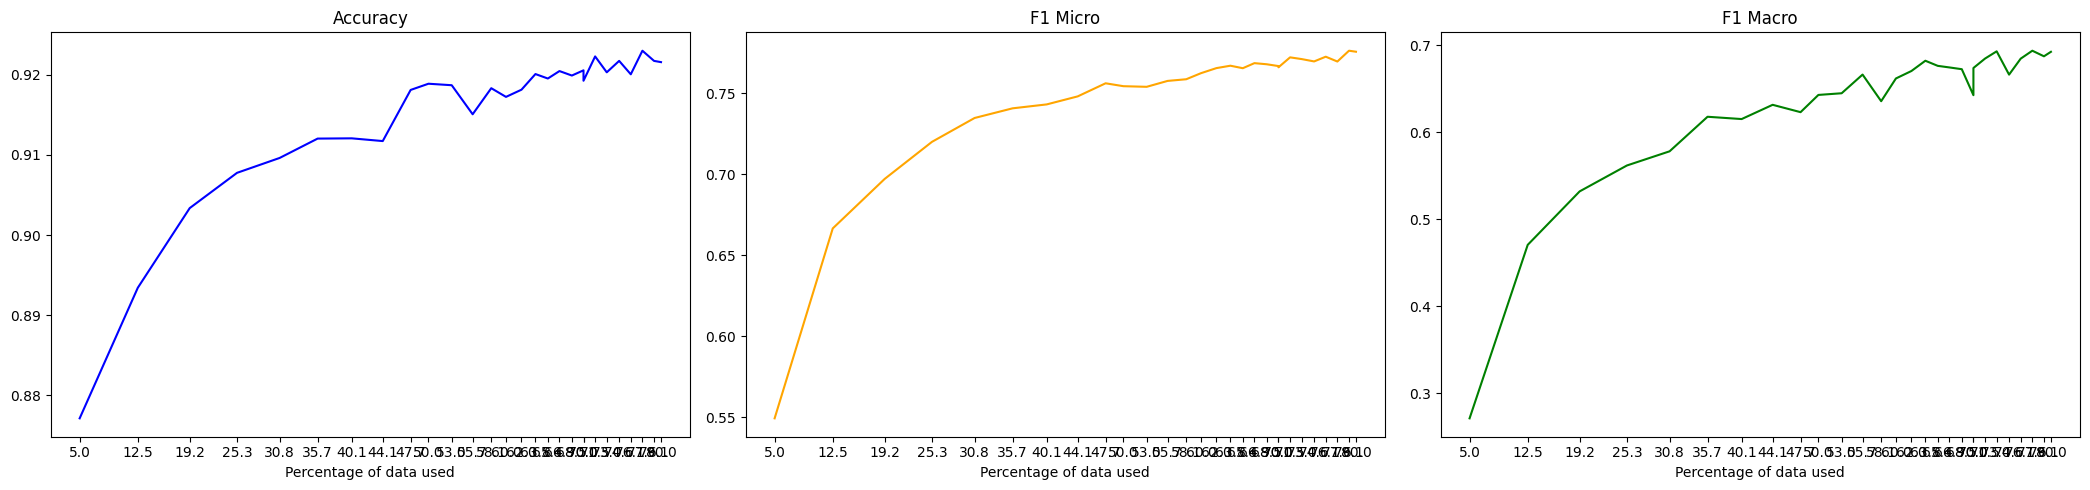

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5799, Accuracy: 0.8262, F1 Micro: 0.3921, F1 Macro: 0.1031
Epoch 2/10, Train Loss: 0.4517, Accuracy: 0.8344, F1 Micro: 0.1933, F1 Macro: 0.0512
Epoch 3/10, Train Loss: 0.4051, Accuracy: 0.8316, F1 Micro: 0.068, F1 Macro: 0.0274
Epoch 4/10, Train Loss: 0.3657, Accuracy: 0.8368, F1 Micro: 0.146, F1 Macro: 0.049
Epoch 5/10, Train Loss: 0.3619, Accuracy: 0.8459, F1 Micro: 0.2447, F1 Macro: 0.086
Epoch 6/10, Train Loss: 0.3378, Accuracy: 0.8532, F1 Micro: 0.3418, F1 Macro: 0.1265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3201, Accuracy: 0.8684, F1 Micro: 0.5, F1 Macro: 0.2319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3026, Accuracy: 0.8717, F1 Micro: 0.5243, F1 Macro: 0.246
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2623, Accuracy: 0.8734, F1 Micro: 0.5965, F1 Macro: 0.2782
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2681, Accuracy: 0.875, F1 Micro: 0.6017, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5174, Accuracy: 0.8342, F1 Micro: 0.267, F1 Macro: 0.0584
Epoch 2/10, Train Loss: 0.3903, Accuracy: 0.8429, F1 Micro: 0.2461, F1 Macro: 0.0821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3567, Accuracy: 0.861, F1 Micro: 0.4442, F1 Macro: 0.1831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3282, Accuracy: 0.876, F1 Micro: 0.5992, F1 Macro: 0.2799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2966, Accuracy: 0.8808, F1 Micro: 0.6189, F1 Macro: 0.2945
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2612, Accuracy: 0.8857, F1 Micro: 0.6343, F1 Macro: 0.3153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2373, Accuracy: 0.8879, F1 Micro: 0.6465, F1 Macro: 0.3427
Epoch 8/10, Train Loss: 0.2128, Accuracy: 0.8901, F1 Micro: 0.6445, F1 Macro: 0.4069
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2084, Accuracy: 0.8927, F1 Micro: 0.6504, F1 Macro: 0.4048
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4809, Accuracy: 0.8348, F1 Micro: 0.112, F1 Macro: 0.0438
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3726, Accuracy: 0.8594, F1 Micro: 0.4038, F1 Macro: 0.1668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3282, Accuracy: 0.877, F1 Micro: 0.6138, F1 Macro: 0.2927
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2874, Accuracy: 0.8847, F1 Micro: 0.6522, F1 Macro: 0.3456
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.245, Accuracy: 0.8935, F1 Micro: 0.6643, F1 Macro: 0.3836
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2107, Accuracy: 0.8937, F1 Micro: 0.6832, F1 Macro: 0.4579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2006, Accuracy: 0.8952, F1 Micro: 0.6875, F1 Macro: 0.4858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1738, Accuracy: 0.8983, F1 Micro: 0.7036, F1 Macro: 0.5177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4625, Accuracy: 0.8417, F1 Micro: 0.1982, F1 Macro: 0.0718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3465, Accuracy: 0.8781, F1 Micro: 0.6059, F1 Macro: 0.2816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2882, Accuracy: 0.8877, F1 Micro: 0.6455, F1 Macro: 0.3419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2496, Accuracy: 0.8949, F1 Micro: 0.6852, F1 Macro: 0.4151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2161, Accuracy: 0.8995, F1 Micro: 0.6988, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1915, Accuracy: 0.9043, F1 Micro: 0.6996, F1 Macro: 0.497
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1707, Accuracy: 0.9065, F1 Micro: 0.7158, F1 Macro: 0.5132
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1498, Accuracy: 0.9034, F1 Micro: 0.7245, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4433, Accuracy: 0.8526, F1 Micro: 0.3679, F1 Macro: 0.1166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3357, Accuracy: 0.8841, F1 Micro: 0.5995, F1 Macro: 0.2953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2708, Accuracy: 0.8912, F1 Micro: 0.6233, F1 Macro: 0.3387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2345, Accuracy: 0.9011, F1 Micro: 0.6871, F1 Macro: 0.4584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2081, Accuracy: 0.9053, F1 Micro: 0.7159, F1 Macro: 0.5227
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1762, Accuracy: 0.9054, F1 Micro: 0.7216, F1 Macro: 0.5393
Epoch 7/10, Train Loss: 0.1559, Accuracy: 0.9076, F1 Micro: 0.7075, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1295, Accuracy: 0.9119, F1 Micro: 0.7324, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1134, Accuracy: 0.9096, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4336, Accuracy: 0.853, F1 Micro: 0.3356, F1 Macro: 0.114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3141, Accuracy: 0.887, F1 Micro: 0.623, F1 Macro: 0.3207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2613, Accuracy: 0.898, F1 Micro: 0.6873, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2212, Accuracy: 0.8999, F1 Micro: 0.7069, F1 Macro: 0.501
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1928, Accuracy: 0.9076, F1 Micro: 0.7233, F1 Macro: 0.5407
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1609, Accuracy: 0.911, F1 Micro: 0.7345, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1373, Accuracy: 0.9124, F1 Micro: 0.7355, F1 Macro: 0.5661
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9134, F1 Micro: 0.7344, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1016, Accuracy: 0.9143, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4248, Accuracy: 0.8654, F1 Micro: 0.47, F1 Macro: 0.1974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3069, Accuracy: 0.8867, F1 Micro: 0.6643, F1 Macro: 0.361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.9018, F1 Micro: 0.6976, F1 Macro: 0.4831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2121, Accuracy: 0.9042, F1 Micro: 0.7071, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9105, F1 Micro: 0.7225, F1 Macro: 0.5624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1588, Accuracy: 0.9109, F1 Micro: 0.75, F1 Macro: 0.5999
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.9088, F1 Micro: 0.7416, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1154, Accuracy: 0.9178, F1 Micro: 0.7553, F1 Macro: 0.6024
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9144, F1 Micro: 0.7504, F1 Macro: 0.6123
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4218, Accuracy: 0.8686, F1 Micro: 0.4983, F1 Macro: 0.2193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2985, Accuracy: 0.8913, F1 Micro: 0.6214, F1 Macro: 0.3264
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2468, Accuracy: 0.9014, F1 Micro: 0.7075, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2056, Accuracy: 0.9053, F1 Micro: 0.7245, F1 Macro: 0.5206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9118, F1 Micro: 0.7441, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1507, Accuracy: 0.9151, F1 Micro: 0.7455, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.9127, F1 Micro: 0.7539, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9178, F1 Micro: 0.7554, F1 Macro: 0.6243
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.912, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4134, Accuracy: 0.8686, F1 Micro: 0.4608, F1 Macro: 0.2077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2898, Accuracy: 0.8977, F1 Micro: 0.658, F1 Macro: 0.3989
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9077, F1 Micro: 0.7096, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.205, Accuracy: 0.9091, F1 Micro: 0.7288, F1 Macro: 0.5639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9149, F1 Micro: 0.7377, F1 Macro: 0.5857
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9166, F1 Micro: 0.7375, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9143, F1 Micro: 0.7513, F1 Macro: 0.5987
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9161, F1 Micro: 0.7499, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0899, Accuracy: 0.9169, F1 Micro: 0.7563, F1 Macro: 0.6401
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4059, Accuracy: 0.8779, F1 Micro: 0.5813, F1 Macro: 0.2716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2844, Accuracy: 0.8972, F1 Micro: 0.6677, F1 Macro: 0.4234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.9071, F1 Micro: 0.7119, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9114, F1 Micro: 0.725, F1 Macro: 0.5419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1716, Accuracy: 0.9145, F1 Micro: 0.7476, F1 Macro: 0.5921
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9175, F1 Micro: 0.7408, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.9183, F1 Micro: 0.749, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1059, Accuracy: 0.9181, F1 Micro: 0.7539, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9176, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8785, F1 Micro: 0.5809, F1 Macro: 0.273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2796, Accuracy: 0.8973, F1 Micro: 0.6689, F1 Macro: 0.407
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.9085, F1 Micro: 0.7122, F1 Macro: 0.5099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.9106, F1 Micro: 0.7433, F1 Macro: 0.5748
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.9152, F1 Micro: 0.7387, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9174, F1 Micro: 0.7558, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1193, Accuracy: 0.9177, F1 Micro: 0.7622, F1 Macro: 0.6184
Epoch 8/10, Train Loss: 0.1029, Accuracy: 0.9181, F1 Micro: 0.7587, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.9165, F1 Micro: 0.7639, F1 Macro: 0.6551
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.8797, F1 Micro: 0.5664, F1 Macro: 0.2638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.902, F1 Micro: 0.6994, F1 Macro: 0.4975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9117, F1 Micro: 0.7277, F1 Macro: 0.5475
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9139, F1 Micro: 0.7461, F1 Macro: 0.5707
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9175, F1 Micro: 0.7368, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9178, F1 Micro: 0.759, F1 Macro: 0.5988
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9178, F1 Micro: 0.743, F1 Macro: 0.6071
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9198, F1 Micro: 0.764, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9199, F1 Micro: 0.7661, F1 Macro: 0.6454
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3964, Accuracy: 0.8814, F1 Micro: 0.6039, F1 Macro: 0.2824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.8977, F1 Micro: 0.6692, F1 Macro: 0.4329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.9111, F1 Micro: 0.725, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9146, F1 Micro: 0.7522, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.913, F1 Micro: 0.7546, F1 Macro: 0.5927
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9193, F1 Micro: 0.75, F1 Macro: 0.6024
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9207, F1 Micro: 0.7485, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0991, Accuracy: 0.9211, F1 Micro: 0.7552, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9193, F1 Micro: 0.7638, F1 Macro: 0.6535
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8834, F1 Micro: 0.5919, F1 Macro: 0.2802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.9018, F1 Micro: 0.7011, F1 Macro: 0.4692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9113, F1 Micro: 0.7244, F1 Macro: 0.5323
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9173, F1 Micro: 0.754, F1 Macro: 0.5919
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9208, F1 Micro: 0.7617, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9204, F1 Micro: 0.7646, F1 Macro: 0.6217
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9201, F1 Micro: 0.7626, F1 Macro: 0.6437
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9161, F1 Micro: 0.7564, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9218, F1 Micro: 0.7694, F1 Macro: 0.6584
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3892, Accuracy: 0.8802, F1 Micro: 0.5442, F1 Macro: 0.2563
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.901, F1 Micro: 0.6841, F1 Macro: 0.4504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9111, F1 Micro: 0.7211, F1 Macro: 0.5526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9163, F1 Micro: 0.7411, F1 Macro: 0.5671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9132, F1 Micro: 0.7538, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9198, F1 Micro: 0.7552, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9142, F1 Micro: 0.7599, F1 Macro: 0.6338
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.922, F1 Micro: 0.7558, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9206, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8827, F1 Micro: 0.5784, F1 Macro: 0.2738
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.9017, F1 Micro: 0.6624, F1 Macro: 0.4576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9107, F1 Micro: 0.7089, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9173, F1 Micro: 0.7384, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.921, F1 Micro: 0.7652, F1 Macro: 0.6079
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9175, F1 Micro: 0.7594, F1 Macro: 0.6233
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9175, F1 Micro: 0.7651, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9213, F1 Micro: 0.7703, F1 Macro: 0.6711
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9152, F1 Micro: 0.7613, F1 Macro: 0.6543
Epoch 10/10, Train Loss: 0.0697, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8845, F1 Micro: 0.5988, F1 Macro: 0.2895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.9035, F1 Micro: 0.6913, F1 Macro: 0.489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9129, F1 Micro: 0.7294, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9188, F1 Micro: 0.7478, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9207, F1 Micro: 0.7598, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9212, F1 Micro: 0.7694, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9239, F1 Micro: 0.7716, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9204, F1 Micro: 0.7722, F1 Macro: 0.6471
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.921, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8837, F1 Micro: 0.5847, F1 Macro: 0.2869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.9019, F1 Micro: 0.7116, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9118, F1 Micro: 0.7359, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9175, F1 Micro: 0.7468, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9213, F1 Micro: 0.7655, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9193, F1 Micro: 0.7667, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9217, F1 Micro: 0.7744, F1 Macro: 0.6679
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9229, F1 Micro: 0.77, F1 Macro: 0.669
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9222, F1 Micro: 0.7688, F1 Macro: 0.6786
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8859, F1 Micro: 0.6159, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2581, Accuracy: 0.9043, F1 Micro: 0.7118, F1 Macro: 0.5265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9123, F1 Micro: 0.7383, F1 Macro: 0.5704
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9161, F1 Micro: 0.729, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9214, F1 Micro: 0.7573, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.921, F1 Micro: 0.762, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9158, F1 Micro: 0.7637, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9211, F1 Micro: 0.7678, F1 Macro: 0.665
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9201, F1 Micro: 0.7665, F1 Macro: 0.6717
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.381, Accuracy: 0.8847, F1 Micro: 0.6048, F1 Macro: 0.3061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.907, F1 Micro: 0.7104, F1 Macro: 0.5164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9128, F1 Micro: 0.739, F1 Macro: 0.5615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9202, F1 Micro: 0.7593, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9203, F1 Micro: 0.7643, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1247, Accuracy: 0.9191, F1 Micro: 0.7706, F1 Macro: 0.635
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9226, F1 Micro: 0.7651, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9187, F1 Micro: 0.771, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9209, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8871, F1 Micro: 0.6314, F1 Macro: 0.3192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9038, F1 Micro: 0.7175, F1 Macro: 0.4859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9108, F1 Micro: 0.743, F1 Macro: 0.562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.917, F1 Micro: 0.7529, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9206, F1 Micro: 0.7663, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9227, F1 Micro: 0.7713, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9187, F1 Micro: 0.7664, F1 Macro: 0.6615
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9202, F1 Micro: 0.7663, F1 Macro: 0.675
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9182, F1 Micro: 0.7664, F1 Macro: 0.678
Epoch 10/10, Train Loss: 0.0623, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.8834, F1 Micro: 0.6438, F1 Macro: 0.3264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9053, F1 Micro: 0.6904, F1 Macro: 0.4851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.914, F1 Micro: 0.7364, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9193, F1 Micro: 0.7621, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9198, F1 Micro: 0.7697, F1 Macro: 0.6258
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9203, F1 Micro: 0.7637, F1 Macro: 0.6449
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9235, F1 Micro: 0.7758, F1 Macro: 0.6611
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9233, F1 Micro: 0.7675, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.924, F1 Micro: 0.7782, F1 Macro: 0.6915
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.8842, F1 Micro: 0.6473, F1 Macro: 0.3291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9049, F1 Micro: 0.6839, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9156, F1 Micro: 0.7379, F1 Macro: 0.551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9178, F1 Micro: 0.7576, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9203, F1 Micro: 0.768, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9217, F1 Micro: 0.7744, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9222, F1 Micro: 0.769, F1 Macro: 0.6581
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9221, F1 Micro: 0.7695, F1 Macro: 0.675
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9227, F1 Micro: 0.7682, F1 Macro: 0.6925
Epoch 10/10, Train Loss: 0.0587, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8884, F1 Micro: 0.6162, F1 Macro: 0.3171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9051, F1 Micro: 0.7167, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9132, F1 Micro: 0.7405, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9184, F1 Micro: 0.7557, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9221, F1 Micro: 0.7637, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.919, F1 Micro: 0.7675, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9233, F1 Micro: 0.7721, F1 Macro: 0.6679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.923, F1 Micro: 0.7748, F1 Macro: 0.6708
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9214, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.8855, F1 Micro: 0.578, F1 Macro: 0.2895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9072, F1 Micro: 0.6949, F1 Macro: 0.4833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9162, F1 Micro: 0.7464, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9211, F1 Micro: 0.7484, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9211, F1 Micro: 0.769, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9234, F1 Micro: 0.7712, F1 Macro: 0.6617
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.911, F1 Micro: 0.757, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9223, F1 Micro: 0.7753, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.922, F1 Micro: 0.7763

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3686, Accuracy: 0.8893, F1 Micro: 0.6356, F1 Macro: 0.3323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9091, F1 Micro: 0.705, F1 Macro: 0.5179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9139, F1 Micro: 0.7431, F1 Macro: 0.5521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9165, F1 Micro: 0.7541, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9216, F1 Micro: 0.7665, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1247, Accuracy: 0.9218, F1 Micro: 0.7722, F1 Macro: 0.6714
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9244, F1 Micro: 0.7678, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9223, F1 Micro: 0.779, F1 Macro: 0.6892
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.924, F1 Micro: 0.7751, F1 Macro: 0.6956
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3685, Accuracy: 0.8921, F1 Micro: 0.6436, F1 Macro: 0.3497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9078, F1 Micro: 0.7073, F1 Macro: 0.5085
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9165, F1 Micro: 0.748, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9208, F1 Micro: 0.7569, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9232, F1 Micro: 0.7773, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9263, F1 Micro: 0.7796, F1 Macro: 0.6787
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9237, F1 Micro: 0.7745, F1 Macro: 0.6656
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9227, F1 Micro: 0.7742, F1 Macro: 0.6664
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9235, F1 Micro: 0.7762, F1 Macro: 0.6938
Epoch 10/10, Train Loss: 0.0624, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3683, Accuracy: 0.8891, F1 Micro: 0.6027, F1 Macro: 0.3079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.904, F1 Micro: 0.7204, F1 Macro: 0.5167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9169, F1 Micro: 0.7327, F1 Macro: 0.555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9183, F1 Micro: 0.7629, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9253, F1 Micro: 0.7771, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9272, F1 Micro: 0.7772, F1 Macro: 0.6639
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9224, F1 Micro: 0.7765, F1 Macro: 0.6732
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9194, F1 Micro: 0.773, F1 Macro: 0.6702
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9237, F1 Micro: 0.7704, F1 Macro: 0.6899
Epoch 10/10, Train Loss: 0.0617, Accuracy

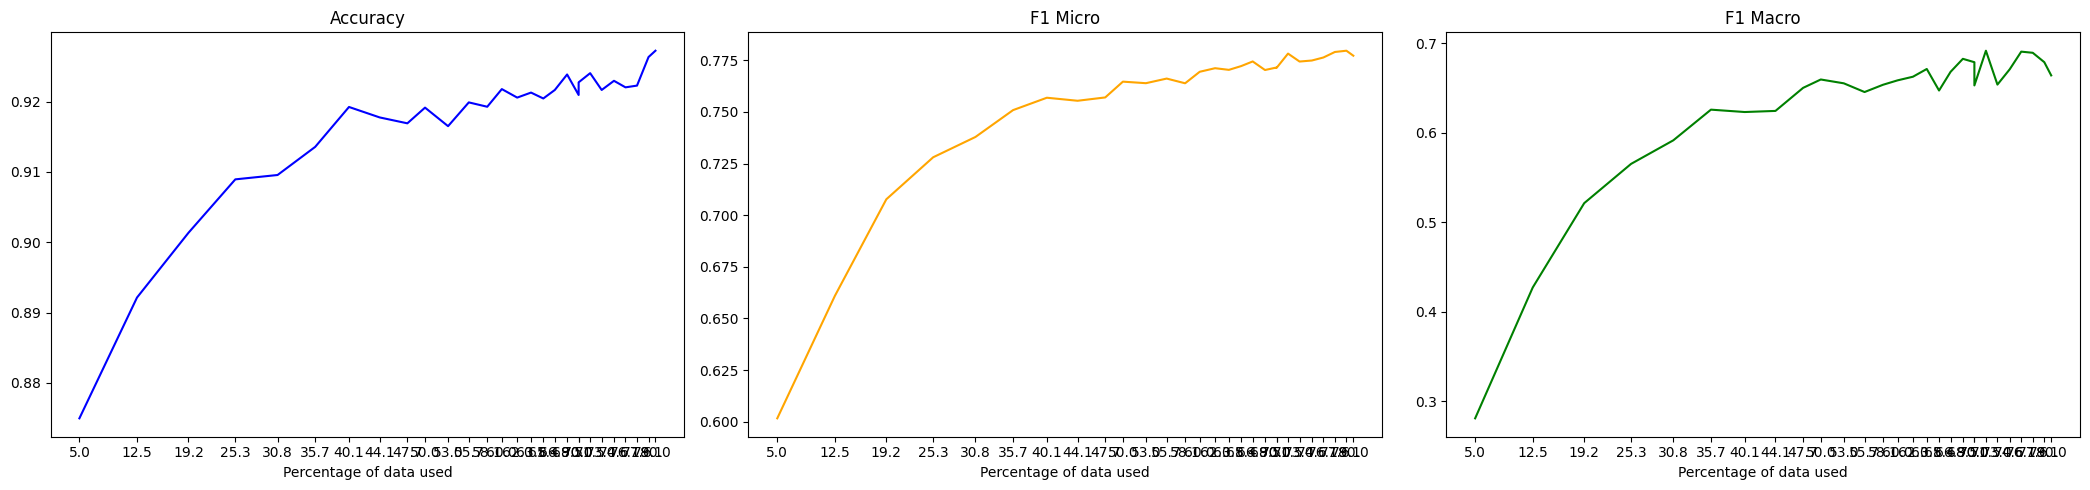

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5976, Accuracy: 0.8313, F1 Micro: 0.2023, F1 Macro: 0.0526
Epoch 2/10, Train Loss: 0.4529, Accuracy: 0.8295, F1 Micro: 0.0511, F1 Macro: 0.0184
Epoch 3/10, Train Loss: 0.425, Accuracy: 0.8349, F1 Micro: 0.1135, F1 Macro: 0.0445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3847, Accuracy: 0.847, F1 Micro: 0.2733, F1 Macro: 0.0921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.379, Accuracy: 0.8488, F1 Micro: 0.2963, F1 Macro: 0.0979
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3536, Accuracy: 0.8566, F1 Micro: 0.4128, F1 Macro: 0.1411
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.346, Accuracy: 0.8661, F1 Micro: 0.448, F1 Macro: 0.1925
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3125, Accuracy: 0.87, F1 Micro: 0.5757, F1 Macro: 0.2665
Epoch 9/10, Train Loss: 0.3022, Accuracy: 0.8743, F1 Micro: 0.5694, F1 Macro: 0.2653
Epoch 10/10, Train Loss: 0.2677, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5212, Accuracy: 0.8286, F1 Micro: 0.0274, F1 Macro: 0.0105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3958, Accuracy: 0.8344, F1 Micro: 0.1007, F1 Macro: 0.0365
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3697, Accuracy: 0.8554, F1 Micro: 0.3745, F1 Macro: 0.1195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.331, Accuracy: 0.8748, F1 Micro: 0.5398, F1 Macro: 0.2473
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3071, Accuracy: 0.8797, F1 Micro: 0.5982, F1 Macro: 0.2867
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2643, Accuracy: 0.884, F1 Micro: 0.6229, F1 Macro: 0.3194
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2512, Accuracy: 0.8876, F1 Micro: 0.6448, F1 Macro: 0.3563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2279, Accuracy: 0.8927, F1 Micro: 0.6556, F1 Macro: 0.4147
Epoch 9/10, Train Loss: 0.2011, Accuracy: 0.8929, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4839, Accuracy: 0.8327, F1 Micro: 0.076, F1 Macro: 0.03
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3726, Accuracy: 0.8601, F1 Micro: 0.4166, F1 Macro: 0.1477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3286, Accuracy: 0.8768, F1 Micro: 0.6066, F1 Macro: 0.2879
Epoch 4/10, Train Loss: 0.2927, Accuracy: 0.8833, F1 Micro: 0.5724, F1 Macro: 0.2837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2578, Accuracy: 0.8901, F1 Micro: 0.6103, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2306, Accuracy: 0.8951, F1 Micro: 0.6625, F1 Macro: 0.4607
Epoch 7/10, Train Loss: 0.2084, Accuracy: 0.8975, F1 Micro: 0.6466, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1766, Accuracy: 0.8984, F1 Micro: 0.7005, F1 Macro: 0.5466
Epoch 9/10, Train Loss: 0.1604, Accuracy: 0.9006, F1 Micro: 0.6992, F1 Macro: 0.5403
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4561, Accuracy: 0.8515, F1 Micro: 0.347, F1 Macro: 0.1073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3543, Accuracy: 0.8751, F1 Micro: 0.5953, F1 Macro: 0.285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.8845, F1 Micro: 0.6418, F1 Macro: 0.3266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2586, Accuracy: 0.8963, F1 Micro: 0.6718, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2244, Accuracy: 0.9014, F1 Micro: 0.6882, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1997, Accuracy: 0.9023, F1 Micro: 0.7012, F1 Macro: 0.5117
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.173, Accuracy: 0.9051, F1 Micro: 0.7018, F1 Macro: 0.5385
Epoch 8/10, Train Loss: 0.1558, Accuracy: 0.9049, F1 Micro: 0.6801, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1301, Accuracy: 0.9016, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4444, Accuracy: 0.8508, F1 Micro: 0.3106, F1 Macro: 0.1007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3384, Accuracy: 0.8802, F1 Micro: 0.6175, F1 Macro: 0.2992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2805, Accuracy: 0.893, F1 Micro: 0.6447, F1 Macro: 0.3715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2419, Accuracy: 0.9006, F1 Micro: 0.6719, F1 Macro: 0.4532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2061, Accuracy: 0.9007, F1 Micro: 0.7166, F1 Macro: 0.5364
Epoch 6/10, Train Loss: 0.1858, Accuracy: 0.9063, F1 Micro: 0.7147, F1 Macro: 0.5306
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.159, Accuracy: 0.9083, F1 Micro: 0.7261, F1 Macro: 0.5706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1338, Accuracy: 0.9073, F1 Micro: 0.7337, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1226, Accuracy: 0.9095, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4323, Accuracy: 0.858, F1 Micro: 0.4162, F1 Macro: 0.1365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3205, Accuracy: 0.8864, F1 Micro: 0.6186, F1 Macro: 0.3159
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2612, Accuracy: 0.8983, F1 Micro: 0.6811, F1 Macro: 0.4566
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2301, Accuracy: 0.9028, F1 Micro: 0.7131, F1 Macro: 0.507
Epoch 5/10, Train Loss: 0.1975, Accuracy: 0.9095, F1 Micro: 0.7095, F1 Macro: 0.5359
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1667, Accuracy: 0.912, F1 Micro: 0.7337, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1436, Accuracy: 0.9127, F1 Micro: 0.7424, F1 Macro: 0.6106
Epoch 8/10, Train Loss: 0.1196, Accuracy: 0.9133, F1 Micro: 0.7408, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1042, Accuracy: 0.9078, F1 Micro: 0.7463, F1 Macro: 0.6177
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4234, Accuracy: 0.8693, F1 Micro: 0.5175, F1 Macro: 0.2248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3069, Accuracy: 0.8879, F1 Micro: 0.6017, F1 Macro: 0.3339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.251, Accuracy: 0.9009, F1 Micro: 0.683, F1 Macro: 0.4787
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2179, Accuracy: 0.9085, F1 Micro: 0.7268, F1 Macro: 0.5455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1889, Accuracy: 0.9116, F1 Micro: 0.7324, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9066, F1 Micro: 0.7377, F1 Macro: 0.5855
Epoch 7/10, Train Loss: 0.1325, Accuracy: 0.9129, F1 Micro: 0.7306, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1189, Accuracy: 0.9142, F1 Micro: 0.7377, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.098, Accuracy: 0.9157, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4175, Accuracy: 0.8669, F1 Micro: 0.4347, F1 Macro: 0.1827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3017, Accuracy: 0.8921, F1 Micro: 0.6364, F1 Macro: 0.3666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.9039, F1 Micro: 0.6903, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9102, F1 Micro: 0.7315, F1 Macro: 0.5704
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.9151, F1 Micro: 0.7269, F1 Macro: 0.5607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9127, F1 Micro: 0.7466, F1 Macro: 0.5837
Epoch 7/10, Train Loss: 0.1293, Accuracy: 0.9165, F1 Micro: 0.735, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9184, F1 Micro: 0.7604, F1 Macro: 0.6461
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9193, F1 Micro: 0.7524, F1 Macro: 0.6432
Epoch 10/10, Train Loss: 0.0839, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4113, Accuracy: 0.8755, F1 Micro: 0.5256, F1 Macro: 0.2409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.892, F1 Micro: 0.6091, F1 Macro: 0.3367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.904, F1 Micro: 0.7125, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1998, Accuracy: 0.9094, F1 Micro: 0.7374, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.173, Accuracy: 0.9158, F1 Micro: 0.7457, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9186, F1 Micro: 0.7474, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1218, Accuracy: 0.9161, F1 Micro: 0.7513, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.9195, F1 Micro: 0.7616, F1 Macro: 0.644
Epoch 9/10, Train Loss: 0.0878, Accuracy: 0.9161, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4112, Accuracy: 0.8766, F1 Micro: 0.536, F1 Macro: 0.2445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.894, F1 Micro: 0.6621, F1 Macro: 0.4379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9068, F1 Micro: 0.7019, F1 Macro: 0.5112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.9105, F1 Micro: 0.7367, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9142, F1 Micro: 0.7511, F1 Macro: 0.5954
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9152, F1 Micro: 0.7557, F1 Macro: 0.6163
Epoch 7/10, Train Loss: 0.1242, Accuracy: 0.9185, F1 Micro: 0.7515, F1 Macro: 0.6252
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.92, F1 Micro: 0.7522, F1 Macro: 0.6255
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9187, F1 Micro: 0.7556, F1 Macro: 0.631
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4005, Accuracy: 0.8741, F1 Micro: 0.6003, F1 Macro: 0.2922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.8972, F1 Micro: 0.6799, F1 Macro: 0.4466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9088, F1 Micro: 0.7216, F1 Macro: 0.55
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9144, F1 Micro: 0.74, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.919, F1 Micro: 0.7496, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9182, F1 Micro: 0.7519, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.92, F1 Micro: 0.765, F1 Macro: 0.6436
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9205, F1 Micro: 0.7609, F1 Macro: 0.6478
Epoch 9/10, Train Loss: 0.0893, Accuracy: 0.9194, F1 Micro: 0.7638, F1 Macro: 0.6457
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.879, F1 Micro: 0.5511, F1 Macro: 0.2593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.8955, F1 Micro: 0.6335, F1 Macro: 0.3819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2295, Accuracy: 0.9119, F1 Micro: 0.7214, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9166, F1 Micro: 0.7519, F1 Macro: 0.5847
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9199, F1 Micro: 0.7494, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.9204, F1 Micro: 0.7633, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9195, F1 Micro: 0.7649, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9189, F1 Micro: 0.7611, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9207, F1 Micro: 0.7662, F1 Macro: 0.6448
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8809, F1 Micro: 0.5785, F1 Macro: 0.2743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9013, F1 Micro: 0.7013, F1 Macro: 0.4908
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9086, F1 Micro: 0.6978, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9137, F1 Micro: 0.7438, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9133, F1 Micro: 0.7603, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9207, F1 Micro: 0.77, F1 Macro: 0.6374
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9199, F1 Micro: 0.7647, F1 Macro: 0.6377
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9146, F1 Micro: 0.7631, F1 Macro: 0.6629
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9196, F1 Micro: 0.7641, F1 Macro: 0.6584
Epoch 10/10, Train Loss: 0.0723, Accuracy: 0.919, F1 Micro: 0.7604, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3944, Accuracy: 0.8814, F1 Micro: 0.5854, F1 Macro: 0.2847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.9009, F1 Micro: 0.6898, F1 Macro: 0.4988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2202, Accuracy: 0.9125, F1 Micro: 0.7248, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9167, F1 Micro: 0.7403, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9197, F1 Micro: 0.7621, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9206, F1 Micro: 0.7631, F1 Macro: 0.6353
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9227, F1 Micro: 0.7698, F1 Macro: 0.6542
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.92, F1 Micro: 0.7664, F1 Macro: 0.6365
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.92, F1 Micro: 0.7616, F1 Macro: 0.6431
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3906, Accuracy: 0.8819, F1 Micro: 0.5807, F1 Macro: 0.2776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.901, F1 Micro: 0.6876, F1 Macro: 0.4654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.9103, F1 Micro: 0.7339, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9148, F1 Micro: 0.7584, F1 Macro: 0.5913
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9191, F1 Micro: 0.755, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9238, F1 Micro: 0.7667, F1 Macro: 0.6339
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9219, F1 Micro: 0.7718, F1 Macro: 0.6394
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9214, F1 Micro: 0.7649, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9214, F1 Micro: 0.773, F1 Macro: 0.6801
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3859, Accuracy: 0.8823, F1 Micro: 0.5988, F1 Macro: 0.3013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.9047, F1 Micro: 0.6906, F1 Macro: 0.4635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9103, F1 Micro: 0.7384, F1 Macro: 0.554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9195, F1 Micro: 0.7542, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9172, F1 Micro: 0.7577, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9201, F1 Micro: 0.7614, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9228, F1 Micro: 0.7735, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9196, F1 Micro: 0.7709, F1 Macro: 0.6717
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9216, F1 Micro: 0.7699, F1 Macro: 0.6774
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8824, F1 Micro: 0.6086, F1 Macro: 0.3036
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.9031, F1 Micro: 0.6973, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9155, F1 Micro: 0.7311, F1 Macro: 0.5762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9168, F1 Micro: 0.7383, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9213, F1 Micro: 0.7663, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9189, F1 Micro: 0.7698, F1 Macro: 0.6636
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9233, F1 Micro: 0.7671, F1 Macro: 0.663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9245, F1 Micro: 0.7776, F1 Macro: 0.6788
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9234, F1 Micro: 0.7694, F1 Macro: 0.6729
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3817, Accuracy: 0.8807, F1 Micro: 0.5546, F1 Macro: 0.2613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.9041, F1 Micro: 0.705, F1 Macro: 0.4905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9139, F1 Micro: 0.7372, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9181, F1 Micro: 0.7577, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9204, F1 Micro: 0.76, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9194, F1 Micro: 0.767, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.921, F1 Micro: 0.7713, F1 Macro: 0.6751
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9189, F1 Micro: 0.7604, F1 Macro: 0.6491
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9213, F1 Micro: 0.7676, F1 Macro: 0.6714
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.8828, F1 Micro: 0.6355, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.903, F1 Micro: 0.6933, F1 Macro: 0.4255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.912, F1 Micro: 0.7331, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9157, F1 Micro: 0.7596, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9218, F1 Micro: 0.7676, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.923, F1 Micro: 0.7716, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.921, F1 Micro: 0.7731, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9214, F1 Micro: 0.7749, F1 Macro: 0.6725
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9237, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8849, F1 Micro: 0.6226, F1 Macro: 0.3275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.9003, F1 Micro: 0.7092, F1 Macro: 0.4678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.913, F1 Micro: 0.7403, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9197, F1 Micro: 0.7494, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9234, F1 Micro: 0.7609, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9235, F1 Micro: 0.7756, F1 Macro: 0.662
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9166, F1 Micro: 0.765, F1 Macro: 0.6797
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9251, F1 Micro: 0.7704, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9229, F1 Micro: 0.7805, F1 Macro: 0.687
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.885, F1 Micro: 0.6234, F1 Macro: 0.3211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.9047, F1 Micro: 0.7127, F1 Macro: 0.518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9139, F1 Micro: 0.7355, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9201, F1 Micro: 0.7616, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9233, F1 Micro: 0.7695, F1 Macro: 0.6439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9225, F1 Micro: 0.7712, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9251, F1 Micro: 0.7715, F1 Macro: 0.6708
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9233, F1 Micro: 0.7703, F1 Macro: 0.6753
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9192, F1 Micro: 0.7685, F1 Macro: 0.676
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8846, F1 Micro: 0.6463, F1 Macro: 0.333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.9074, F1 Micro: 0.6988, F1 Macro: 0.4877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9144, F1 Micro: 0.7392, F1 Macro: 0.5569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9178, F1 Micro: 0.7554, F1 Macro: 0.6042
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9252, F1 Micro: 0.7752, F1 Macro: 0.6379
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9202, F1 Micro: 0.7707, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9231, F1 Micro: 0.777, F1 Macro: 0.6837
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9231, F1 Micro: 0.7723, F1 Macro: 0.6674
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9229, F1 Micro: 0.774, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.8873, F1 Micro: 0.6056, F1 Macro: 0.3222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9067, F1 Micro: 0.7167, F1 Macro: 0.5153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2094, Accuracy: 0.9156, F1 Micro: 0.7477, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9208, F1 Micro: 0.7643, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9238, F1 Micro: 0.7668, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9242, F1 Micro: 0.7721, F1 Macro: 0.6738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.924, F1 Micro: 0.7759, F1 Macro: 0.6868
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9209, F1 Micro: 0.7772, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.8827, F1 Micro: 0.5645, F1 Macro: 0.28
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9041, F1 Micro: 0.7159, F1 Macro: 0.531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9154, F1 Micro: 0.7476, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.92, F1 Micro: 0.7601, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9183, F1 Micro: 0.7681, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9249, F1 Micro: 0.7731, F1 Macro: 0.6762
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9239, F1 Micro: 0.7696, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9213, F1 Micro: 0.777, F1 Macro: 0.691
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9215, F1 Micro: 0.7717, F1 Macro: 0.6806
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8874, F1 Micro: 0.6104, F1 Macro: 0.3149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.9059, F1 Micro: 0.7043, F1 Macro: 0.5006
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9154, F1 Micro: 0.7497, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9224, F1 Micro: 0.7629, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9249, F1 Micro: 0.7715, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9225, F1 Micro: 0.7731, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9248, F1 Micro: 0.7755, F1 Macro: 0.6476
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9225, F1 Micro: 0.7726, F1 Macro: 0.6887
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9214, F1 Micro: 0.7707, F1 Macro: 0.6711
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3681, Accuracy: 0.8885, F1 Micro: 0.6286, F1 Macro: 0.3392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.906, F1 Micro: 0.6863, F1 Macro: 0.4748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9172, F1 Micro: 0.7323, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9203, F1 Micro: 0.7481, F1 Macro: 0.6071
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9246, F1 Micro: 0.7641, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1203, Accuracy: 0.9247, F1 Micro: 0.7718, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9223, F1 Micro: 0.773, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9261, F1 Micro: 0.7731, F1 Macro: 0.6773
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8906, F1 Micro: 0.6497, F1 Macro: 0.3565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9101, F1 Micro: 0.7252, F1 Macro: 0.5386
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9143, F1 Micro: 0.7092, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9218, F1 Micro: 0.7601, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9253, F1 Micro: 0.7763, F1 Macro: 0.6585
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9211, F1 Micro: 0.7748, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9244, F1 Micro: 0.7798, F1 Macro: 0.6749
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9262, F1 Micro: 0.7746, F1 Macro: 0.6801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9257, F1 Micro: 0.7821, F1 Macro: 0.702
Epoch 10/10, Train Loss: 0.0619, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.8861, F1 Micro: 0.6623, F1 Macro: 0.415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.9076, F1 Micro: 0.7244, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9169, F1 Micro: 0.7411, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9211, F1 Micro: 0.7627, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9196, F1 Micro: 0.77, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9238, F1 Micro: 0.7714, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9223, F1 Micro: 0.7728, F1 Macro: 0.6735
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9195, F1 Micro: 0.7725, F1 Macro: 0.6818
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9241, F1 Micro: 0.7724, F1 Macro: 0.6903
Higher F1 

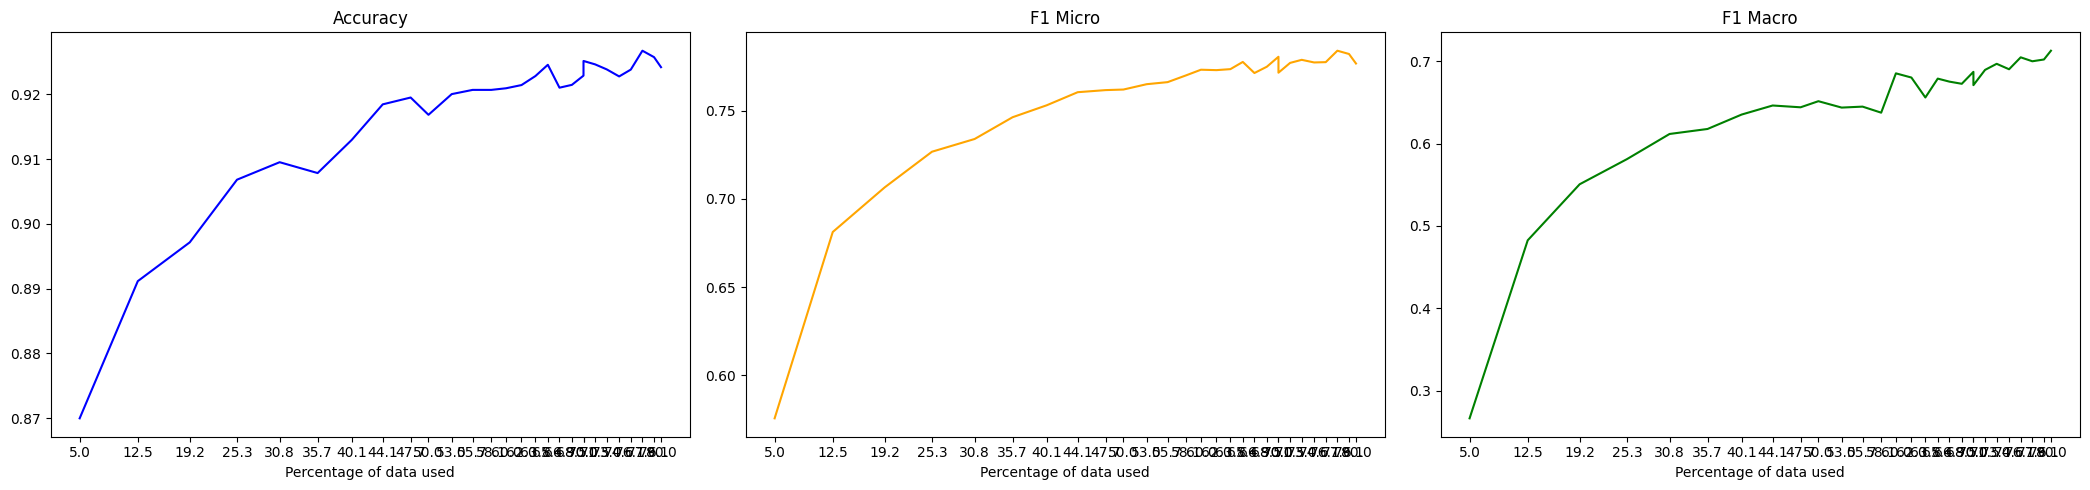

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6124, Accuracy: 0.8295, F1 Micro: 0.1273, F1 Macro: 0.0425
Epoch 2/10, Train Loss: 0.4669, Accuracy: 0.8283, F1 Micro: 0.0135, F1 Macro: 0.006
Epoch 3/10, Train Loss: 0.4072, Accuracy: 0.8326, F1 Micro: 0.0718, F1 Macro: 0.0278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3847, Accuracy: 0.838, F1 Micro: 0.1376, F1 Macro: 0.0524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3789, Accuracy: 0.8464, F1 Micro: 0.2428, F1 Macro: 0.0852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3643, Accuracy: 0.8568, F1 Micro: 0.3734, F1 Macro: 0.1234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3388, Accuracy: 0.8677, F1 Micro: 0.4735, F1 Macro: 0.2056
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3082, Accuracy: 0.8719, F1 Micro: 0.5043, F1 Macro: 0.2334
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2915, Accuracy: 0.8765, F1 Micro: 0.545, F1 Macro: 0.2588
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5411, Accuracy: 0.829, F1 Micro: 0.0223, F1 Macro: 0.0097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.398, Accuracy: 0.837, F1 Micro: 0.1301, F1 Macro: 0.0489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3649, Accuracy: 0.8563, F1 Micro: 0.3554, F1 Macro: 0.1238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3306, Accuracy: 0.876, F1 Micro: 0.5768, F1 Macro: 0.267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2956, Accuracy: 0.8804, F1 Micro: 0.5836, F1 Macro: 0.2776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2781, Accuracy: 0.8848, F1 Micro: 0.6056, F1 Macro: 0.3019
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.235, Accuracy: 0.8836, F1 Micro: 0.6619, F1 Macro: 0.3628
Epoch 8/10, Train Loss: 0.2338, Accuracy: 0.8902, F1 Micro: 0.6305, F1 Macro: 0.3639
Epoch 9/10, Train Loss: 0.1997, Accuracy: 0.8928, F1 Micro: 0.6567, F1 Macro: 0.4264
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4913, Accuracy: 0.8355, F1 Micro: 0.1383, F1 Macro: 0.0445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3776, Accuracy: 0.8604, F1 Micro: 0.4066, F1 Macro: 0.1448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3263, Accuracy: 0.8801, F1 Micro: 0.57, F1 Macro: 0.2651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2832, Accuracy: 0.8877, F1 Micro: 0.6335, F1 Macro: 0.3126
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2454, Accuracy: 0.8925, F1 Micro: 0.6387, F1 Macro: 0.3492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2172, Accuracy: 0.8972, F1 Micro: 0.6805, F1 Macro: 0.4485
Epoch 7/10, Train Loss: 0.1978, Accuracy: 0.8973, F1 Micro: 0.6784, F1 Macro: 0.4827
Epoch 8/10, Train Loss: 0.1772, Accuracy: 0.8999, F1 Micro: 0.6692, F1 Macro: 0.4377
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1537, Accuracy: 0.9037, F1 Micro: 0.7101, F1 Macro: 0.5085
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.465, Accuracy: 0.838, F1 Micro: 0.1492, F1 Macro: 0.0539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3519, Accuracy: 0.8775, F1 Micro: 0.5792, F1 Macro: 0.2682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2903, Accuracy: 0.8877, F1 Micro: 0.6236, F1 Macro: 0.3101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2563, Accuracy: 0.897, F1 Micro: 0.6663, F1 Macro: 0.4271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2256, Accuracy: 0.8999, F1 Micro: 0.6879, F1 Macro: 0.4712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1884, Accuracy: 0.8997, F1 Micro: 0.7088, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.17, Accuracy: 0.9062, F1 Micro: 0.7152, F1 Macro: 0.5375
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1457, Accuracy: 0.9072, F1 Micro: 0.7247, F1 Macro: 0.5435
Epoch 9/10, Train Loss: 0.1206, Accuracy: 0.909, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4506, Accuracy: 0.852, F1 Micro: 0.3642, F1 Macro: 0.1112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.338, Accuracy: 0.8808, F1 Micro: 0.6062, F1 Macro: 0.2854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2744, Accuracy: 0.8929, F1 Micro: 0.619, F1 Macro: 0.3534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2435, Accuracy: 0.9009, F1 Micro: 0.6725, F1 Macro: 0.4429
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2095, Accuracy: 0.9025, F1 Micro: 0.7087, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1833, Accuracy: 0.9089, F1 Micro: 0.7191, F1 Macro: 0.5234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1513, Accuracy: 0.9095, F1 Micro: 0.7309, F1 Macro: 0.5548
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1304, Accuracy: 0.9095, F1 Micro: 0.7395, F1 Macro: 0.5728
Epoch 9/10, Train Loss: 0.1119, Accuracy: 0.9119, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4386, Accuracy: 0.8488, F1 Micro: 0.2871, F1 Macro: 0.0959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3193, Accuracy: 0.8845, F1 Micro: 0.6261, F1 Macro: 0.3101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2627, Accuracy: 0.8964, F1 Micro: 0.6847, F1 Macro: 0.44
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.229, Accuracy: 0.8951, F1 Micro: 0.7088, F1 Macro: 0.5039
Epoch 5/10, Train Loss: 0.201, Accuracy: 0.9075, F1 Micro: 0.7077, F1 Macro: 0.5
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1709, Accuracy: 0.9102, F1 Micro: 0.7248, F1 Macro: 0.5431
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1447, Accuracy: 0.9127, F1 Micro: 0.7267, F1 Macro: 0.5498
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1247, Accuracy: 0.9132, F1 Micro: 0.7271, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.107, Accuracy: 0.9136, F1 Micro: 0.73

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4265, Accuracy: 0.8551, F1 Micro: 0.3464, F1 Macro: 0.1196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3028, Accuracy: 0.8889, F1 Micro: 0.6452, F1 Macro: 0.3472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2518, Accuracy: 0.8964, F1 Micro: 0.6963, F1 Macro: 0.4383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2122, Accuracy: 0.9005, F1 Micro: 0.7177, F1 Macro: 0.5393
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9089, F1 Micro: 0.7213, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1626, Accuracy: 0.9122, F1 Micro: 0.7437, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1323, Accuracy: 0.9151, F1 Micro: 0.7444, F1 Macro: 0.5837
Epoch 8/10, Train Loss: 0.1143, Accuracy: 0.9162, F1 Micro: 0.7434, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0972, Accuracy: 0.915, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4237, Accuracy: 0.8677, F1 Micro: 0.4771, F1 Macro: 0.1892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.302, Accuracy: 0.8887, F1 Micro: 0.5948, F1 Macro: 0.3137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2467, Accuracy: 0.9014, F1 Micro: 0.666, F1 Macro: 0.4242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2118, Accuracy: 0.9036, F1 Micro: 0.7274, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1842, Accuracy: 0.9137, F1 Micro: 0.7447, F1 Macro: 0.5656
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9122, F1 Micro: 0.7369, F1 Macro: 0.5812
Epoch 7/10, Train Loss: 0.1267, Accuracy: 0.9153, F1 Micro: 0.7397, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9159, F1 Micro: 0.7525, F1 Macro: 0.6266
Epoch 9/10, Train Loss: 0.0929, Accuracy: 0.9163, F1 Micro: 0.75, F1 Macro: 0.6325
Epoch 10/10, Train Loss: 0.0824, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.8744, F1 Micro: 0.5436, F1 Macro: 0.2388
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2918, Accuracy: 0.8923, F1 Micro: 0.6257, F1 Macro: 0.3344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2421, Accuracy: 0.9009, F1 Micro: 0.7031, F1 Macro: 0.4987
Epoch 4/10, Train Loss: 0.208, Accuracy: 0.9055, F1 Micro: 0.6816, F1 Macro: 0.5096
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9135, F1 Micro: 0.7392, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9123, F1 Micro: 0.7459, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9155, F1 Micro: 0.7504, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.9168, F1 Micro: 0.7535, F1 Macro: 0.6128
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9165, F1 Micro: 0.7514, F1 Macro: 0.6238
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4115, Accuracy: 0.8748, F1 Micro: 0.5042, F1 Macro: 0.231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2861, Accuracy: 0.8962, F1 Micro: 0.6566, F1 Macro: 0.3968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.904, F1 Micro: 0.7114, F1 Macro: 0.4795
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.9107, F1 Micro: 0.7253, F1 Macro: 0.5352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.9149, F1 Micro: 0.7419, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9166, F1 Micro: 0.7544, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.12, Accuracy: 0.9143, F1 Micro: 0.7548, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.9146, F1 Micro: 0.7553, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.088

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4108, Accuracy: 0.8778, F1 Micro: 0.5515, F1 Macro: 0.2517
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.8954, F1 Micro: 0.6861, F1 Macro: 0.4352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9064, F1 Micro: 0.7065, F1 Macro: 0.484
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.9129, F1 Micro: 0.7202, F1 Macro: 0.5466
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9083, F1 Micro: 0.7445, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9177, F1 Micro: 0.7522, F1 Macro: 0.599
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.9109, F1 Micro: 0.7466, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9178, F1 Micro: 0.7588, F1 Macro: 0.6432
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9132, F1 Micro: 0.7541, F1 Macro: 0.641
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3978, Accuracy: 0.8793, F1 Micro: 0.5601, F1 Macro: 0.2609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.8983, F1 Micro: 0.6895, F1 Macro: 0.4314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2273, Accuracy: 0.9073, F1 Micro: 0.7169, F1 Macro: 0.5211
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9102, F1 Micro: 0.7008, F1 Macro: 0.53
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9163, F1 Micro: 0.7427, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9188, F1 Micro: 0.7526, F1 Macro: 0.6017
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9189, F1 Micro: 0.7514, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9195, F1 Micro: 0.7561, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0835, Accuracy: 0.9188, F1 Micro: 0.7631, F1 Macro: 0.6811
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4003, Accuracy: 0.8795, F1 Micro: 0.5873, F1 Macro: 0.2767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2728, Accuracy: 0.901, F1 Micro: 0.6843, F1 Macro: 0.4344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.9095, F1 Micro: 0.7254, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9126, F1 Micro: 0.7443, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9202, F1 Micro: 0.7593, F1 Macro: 0.6048
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9174, F1 Micro: 0.7564, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9174, F1 Micro: 0.7626, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9156, F1 Micro: 0.763, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9208, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.8725, F1 Micro: 0.4743, F1 Macro: 0.2147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.9006, F1 Micro: 0.6881, F1 Macro: 0.4458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2287, Accuracy: 0.9091, F1 Micro: 0.7262, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9156, F1 Micro: 0.7363, F1 Macro: 0.5664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9195, F1 Micro: 0.758, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.919, F1 Micro: 0.7636, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9233, F1 Micro: 0.7671, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9197, F1 Micro: 0.7677, F1 Macro: 0.6767
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.9217, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3996, Accuracy: 0.8807, F1 Micro: 0.5705, F1 Macro: 0.2618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.9024, F1 Micro: 0.6981, F1 Macro: 0.4712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9114, F1 Micro: 0.7148, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9168, F1 Micro: 0.7488, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9155, F1 Micro: 0.7605, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9207, F1 Micro: 0.767, F1 Macro: 0.6465
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9218, F1 Micro: 0.7569, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9217, F1 Micro: 0.7711, F1 Macro: 0.6796
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9185, F1 Micro: 0.766, F1 Macro: 0.6681
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.881, F1 Micro: 0.5831, F1 Macro: 0.2678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.9032, F1 Micro: 0.6966, F1 Macro: 0.4698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9122, F1 Micro: 0.718, F1 Macro: 0.541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9182, F1 Micro: 0.7598, F1 Macro: 0.605
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9208, F1 Micro: 0.7533, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9214, F1 Micro: 0.766, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9222, F1 Micro: 0.7681, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9229, F1 Micro: 0.7687, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9224, F1 Micro: 0.7665, F1 Macro: 0.6817
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8814, F1 Micro: 0.6291, F1 Macro: 0.2997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9018, F1 Micro: 0.7007, F1 Macro: 0.492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.9056, F1 Micro: 0.7395, F1 Macro: 0.5702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9104, F1 Micro: 0.7523, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9164, F1 Micro: 0.7635, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9206, F1 Micro: 0.765, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9234, F1 Micro: 0.7715, F1 Macro: 0.6714
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9222, F1 Micro: 0.77, F1 Macro: 0.6706
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9244, F1 Micro: 0.7705, F1 Macro: 0.6914
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8805, F1 Micro: 0.6331, F1 Macro: 0.3076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9033, F1 Micro: 0.6896, F1 Macro: 0.4549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2187, Accuracy: 0.9104, F1 Micro: 0.7436, F1 Macro: 0.5598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9191, F1 Micro: 0.7554, F1 Macro: 0.6002
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9178, F1 Micro: 0.754, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9176, F1 Micro: 0.7638, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9217, F1 Micro: 0.7725, F1 Macro: 0.6563
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9226, F1 Micro: 0.771, F1 Macro: 0.6826
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9228, F1 Micro: 0.7656, F1 Macro: 0.6861
Epoch 10/10, Train Loss: 0.0665, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3855, Accuracy: 0.8844, F1 Micro: 0.6177, F1 Macro: 0.2932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9011, F1 Micro: 0.7094, F1 Macro: 0.4856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.9124, F1 Micro: 0.7413, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9185, F1 Micro: 0.7614, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9204, F1 Micro: 0.7642, F1 Macro: 0.6285
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9193, F1 Micro: 0.7721, F1 Macro: 0.6463
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9224, F1 Micro: 0.7706, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9215, F1 Micro: 0.778, F1 Macro: 0.6972
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9229, F1 Micro: 0.7746, F1 Macro: 0.6959
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3838, Accuracy: 0.8851, F1 Micro: 0.6086, F1 Macro: 0.2927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9026, F1 Micro: 0.7113, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9125, F1 Micro: 0.7443, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9179, F1 Micro: 0.7634, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.924, F1 Micro: 0.7683, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9234, F1 Micro: 0.7721, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9259, F1 Micro: 0.7753, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9216, F1 Micro: 0.7761, F1 Macro: 0.6876
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3855, Accuracy: 0.8848, F1 Micro: 0.6201, F1 Macro: 0.2995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9012, F1 Micro: 0.7109, F1 Macro: 0.5115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9131, F1 Micro: 0.7396, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9191, F1 Micro: 0.7563, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9208, F1 Micro: 0.7668, F1 Macro: 0.6217
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.9245, F1 Micro: 0.7634, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9217, F1 Micro: 0.7748, F1 Macro: 0.6759
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9204, F1 Micro: 0.7731, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9224, F1 Micro: 0.7723, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8848, F1 Micro: 0.6119, F1 Macro: 0.2987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9039, F1 Micro: 0.6938, F1 Macro: 0.4523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9116, F1 Micro: 0.7449, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9191, F1 Micro: 0.7636, F1 Macro: 0.6009
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9203, F1 Micro: 0.7571, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9239, F1 Micro: 0.7738, F1 Macro: 0.6511
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.921, F1 Micro: 0.7714, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9256, F1 Micro: 0.7825, F1 Macro: 0.701
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9236, F1 Micro: 0.7668, F1 Macro: 0.6867
Epoch 10/10, Train Loss: 0.0621, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8867, F1 Micro: 0.6193, F1 Macro: 0.2977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9076, F1 Micro: 0.7128, F1 Macro: 0.4898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9137, F1 Micro: 0.7237, F1 Macro: 0.5214
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.919, F1 Micro: 0.7567, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9211, F1 Micro: 0.769, F1 Macro: 0.6285
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9194, F1 Micro: 0.7717, F1 Macro: 0.6572
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9206, F1 Micro: 0.7719, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.923, F1 Micro: 0.7752, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8847, F1 Micro: 0.6162, F1 Macro: 0.3021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9043, F1 Micro: 0.7159, F1 Macro: 0.4977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9149, F1 Micro: 0.7483, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9197, F1 Micro: 0.752, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9252, F1 Micro: 0.7742, F1 Macro: 0.6407
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9226, F1 Micro: 0.7667, F1 Macro: 0.6622
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9218, F1 Micro: 0.7738, F1 Macro: 0.6799
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9202, F1 Micro: 0.7723, F1 Macro: 0.6805
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9233, F1 Micro: 0.7764, F1 Macro: 0.6985
Epoch 10/10, Train Loss: 0.0666, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8864, F1 Micro: 0.603, F1 Macro: 0.294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9076, F1 Micro: 0.7097, F1 Macro: 0.5296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.9136, F1 Micro: 0.7452, F1 Macro: 0.5754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9174, F1 Micro: 0.7646, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9234, F1 Micro: 0.7757, F1 Macro: 0.665
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9249, F1 Micro: 0.7739, F1 Macro: 0.6781
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9225, F1 Micro: 0.7721, F1 Macro: 0.6792
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9243, F1 Micro: 0.7749, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.924, F1 Micro: 0.7758, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8885, F1 Micro: 0.6135, F1 Macro: 0.3085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9076, F1 Micro: 0.7019, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9168, F1 Micro: 0.7437, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.922, F1 Micro: 0.7497, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9234, F1 Micro: 0.7743, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9244, F1 Micro: 0.7763, F1 Macro: 0.6627
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9264, F1 Micro: 0.7749, F1 Macro: 0.6679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9251, F1 Micro: 0.7812, F1 Macro: 0.7032
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9242, F1 Micro: 0.7768, F1 Macro: 0.6885
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8869, F1 Micro: 0.5952, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.9068, F1 Micro: 0.712, F1 Macro: 0.5111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9169, F1 Micro: 0.7364, F1 Macro: 0.5671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9214, F1 Micro: 0.7604, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.9222, F1 Micro: 0.7723, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9209, F1 Micro: 0.7742, F1 Macro: 0.6813
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9246, F1 Micro: 0.7684, F1 Macro: 0.6897
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.924, F1 Micro: 0.772, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9226, F1 Micro: 0.7767, F1 Macro: 0.7029
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3723, Accuracy: 0.8858, F1 Micro: 0.5921, F1 Macro: 0.2885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9073, F1 Micro: 0.7225, F1 Macro: 0.5308
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9152, F1 Micro: 0.7558, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9219, F1 Micro: 0.7613, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9231, F1 Micro: 0.7777, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9239, F1 Micro: 0.7708, F1 Macro: 0.6759
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9251, F1 Micro: 0.7734, F1 Macro: 0.6811
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9245, F1 Micro: 0.7744, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9233, F1 Micro: 0.7806, F1 Macro: 0.6973
Epoch 10/10, Train Loss: 0.0591, Accur

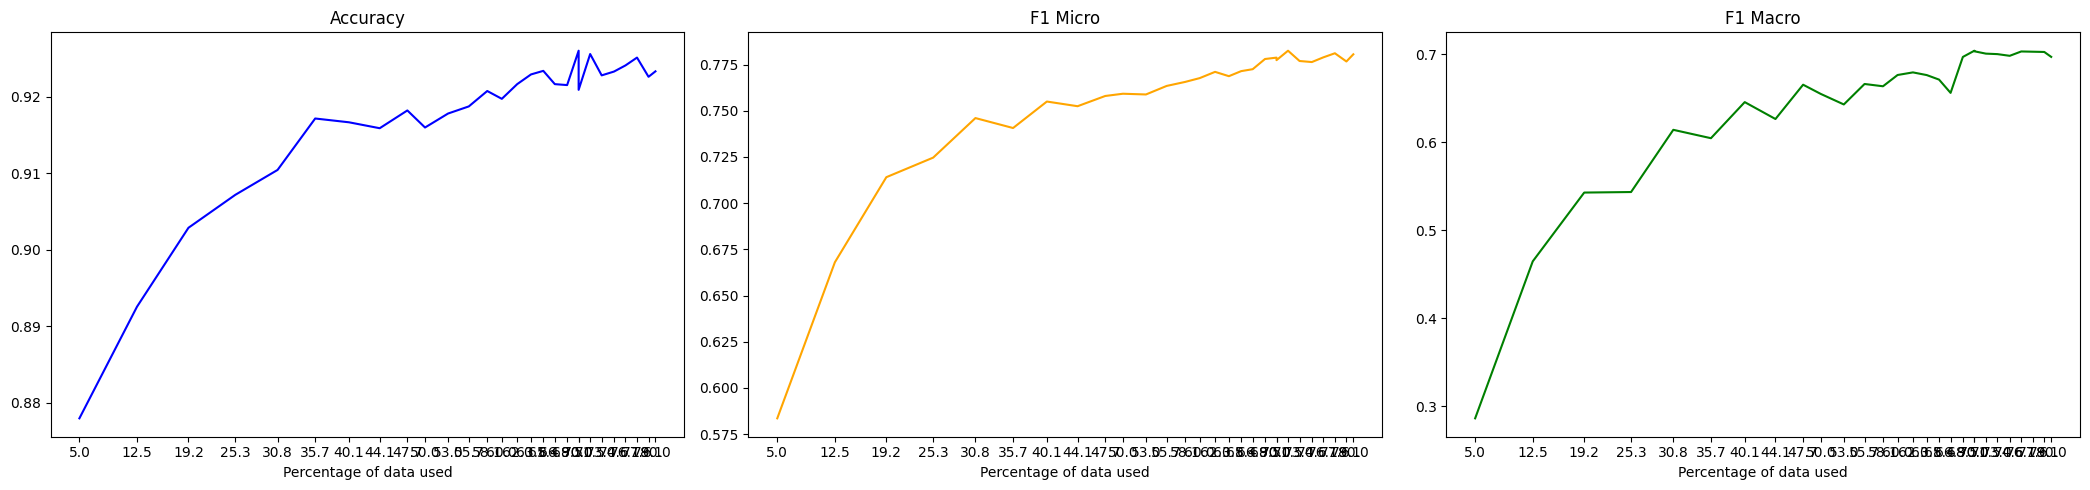

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6246, Accuracy: 0.8182, F1 Micro: 0.1799, F1 Macro: 0.0858
Epoch 2/10, Train Loss: 0.4638, Accuracy: 0.833, F1 Micro: 0.0996, F1 Macro: 0.0359
Epoch 3/10, Train Loss: 0.4095, Accuracy: 0.8315, F1 Micro: 0.0624, F1 Macro: 0.0249
Epoch 4/10, Train Loss: 0.4064, Accuracy: 0.8374, F1 Micro: 0.1245, F1 Macro: 0.0484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3745, Accuracy: 0.8494, F1 Micro: 0.2754, F1 Macro: 0.0936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3744, Accuracy: 0.8575, F1 Micro: 0.3823, F1 Macro: 0.1266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.347, Accuracy: 0.8657, F1 Micro: 0.4875, F1 Macro: 0.2062
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.327, Accuracy: 0.8752, F1 Micro: 0.5421, F1 Macro: 0.2529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2895, Accuracy: 0.8767, F1 Micro: 0.5895, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5359, Accuracy: 0.8327, F1 Micro: 0.0907, F1 Macro: 0.0334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4004, Accuracy: 0.8374, F1 Micro: 0.1242, F1 Macro: 0.0487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3669, Accuracy: 0.8597, F1 Micro: 0.4332, F1 Macro: 0.1379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3359, Accuracy: 0.8748, F1 Micro: 0.6045, F1 Macro: 0.2814
Epoch 5/10, Train Loss: 0.2974, Accuracy: 0.8808, F1 Micro: 0.5915, F1 Macro: 0.2841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2674, Accuracy: 0.8866, F1 Micro: 0.6403, F1 Macro: 0.3417
Epoch 7/10, Train Loss: 0.2516, Accuracy: 0.89, F1 Micro: 0.636, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2307, Accuracy: 0.8914, F1 Micro: 0.6646, F1 Macro: 0.4403
Epoch 9/10, Train Loss: 0.1963, Accuracy: 0.8913, F1 Micro: 0.6297, F1 Macro: 0.3932
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4861, Accuracy: 0.8296, F1 Micro: 0.0273, F1 Macro: 0.0119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3741, Accuracy: 0.8598, F1 Micro: 0.399, F1 Macro: 0.1279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3302, Accuracy: 0.8779, F1 Micro: 0.6204, F1 Macro: 0.308
Epoch 4/10, Train Loss: 0.2872, Accuracy: 0.8864, F1 Micro: 0.5984, F1 Macro: 0.3315
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2562, Accuracy: 0.8944, F1 Micro: 0.6707, F1 Macro: 0.4468
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2225, Accuracy: 0.8954, F1 Micro: 0.6879, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1917, Accuracy: 0.897, F1 Micro: 0.6999, F1 Macro: 0.5201
Epoch 8/10, Train Loss: 0.172, Accuracy: 0.8995, F1 Micro: 0.6959, F1 Macro: 0.5229
Epoch 9/10, Train Loss: 0.1562, Accuracy: 0.8997, F1 Micro: 0.691, F1 Macro: 0.5468
Epoch 10/10, Train Loss: 0.1381, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4632, Accuracy: 0.8334, F1 Micro: 0.0766, F1 Macro: 0.0306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3602, Accuracy: 0.8767, F1 Micro: 0.5856, F1 Macro: 0.2746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2924, Accuracy: 0.888, F1 Micro: 0.6431, F1 Macro: 0.3499
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2542, Accuracy: 0.897, F1 Micro: 0.6767, F1 Macro: 0.4743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2223, Accuracy: 0.8999, F1 Micro: 0.6988, F1 Macro: 0.5079
Epoch 6/10, Train Loss: 0.1916, Accuracy: 0.9017, F1 Micro: 0.6976, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1669, Accuracy: 0.9038, F1 Micro: 0.7175, F1 Macro: 0.564
Epoch 8/10, Train Loss: 0.1409, Accuracy: 0.9059, F1 Micro: 0.7088, F1 Macro: 0.5563
Epoch 9/10, Train Loss: 0.1243, Accuracy: 0.9066, F1 Micro: 0.7136, F1 Macro: 0.5658
Epoch 10/10, Train Loss: 0.1092, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4492, Accuracy: 0.8452, F1 Micro: 0.2258, F1 Macro: 0.0795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3328, Accuracy: 0.8821, F1 Micro: 0.6119, F1 Macro: 0.3058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2782, Accuracy: 0.8945, F1 Micro: 0.6698, F1 Macro: 0.4044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2386, Accuracy: 0.8991, F1 Micro: 0.6726, F1 Macro: 0.477
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2046, Accuracy: 0.9038, F1 Micro: 0.7061, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1769, Accuracy: 0.9055, F1 Micro: 0.7107, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1578, Accuracy: 0.9052, F1 Micro: 0.7187, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1404, Accuracy: 0.9095, F1 Micro: 0.7256, F1 Macro: 0.576
Epoch 9/10, Train Loss: 0.122, Accuracy: 0.9085, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4359, Accuracy: 0.8563, F1 Micro: 0.4011, F1 Macro: 0.1202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3177, Accuracy: 0.8856, F1 Micro: 0.6212, F1 Macro: 0.3109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2588, Accuracy: 0.8965, F1 Micro: 0.6633, F1 Macro: 0.4403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2216, Accuracy: 0.9016, F1 Micro: 0.6971, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1912, Accuracy: 0.9058, F1 Micro: 0.7118, F1 Macro: 0.5272
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1636, Accuracy: 0.9084, F1 Micro: 0.7391, F1 Macro: 0.5766
Epoch 7/10, Train Loss: 0.1476, Accuracy: 0.9107, F1 Micro: 0.7112, F1 Macro: 0.5415
Epoch 8/10, Train Loss: 0.1257, Accuracy: 0.9094, F1 Micro: 0.731, F1 Macro: 0.5878
Epoch 9/10, Train Loss: 0.1094, Accuracy: 0.9135, F1 Micro: 0.738, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4306, Accuracy: 0.8606, F1 Micro: 0.4223, F1 Macro: 0.1402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.8893, F1 Micro: 0.6173, F1 Macro: 0.3167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2495, Accuracy: 0.8987, F1 Micro: 0.6937, F1 Macro: 0.5009
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2178, Accuracy: 0.9053, F1 Micro: 0.7075, F1 Macro: 0.511
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1825, Accuracy: 0.9081, F1 Micro: 0.7247, F1 Macro: 0.5631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.9092, F1 Micro: 0.7329, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1309, Accuracy: 0.9104, F1 Micro: 0.7347, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1163, Accuracy: 0.9131, F1 Micro: 0.7415, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4191, Accuracy: 0.8701, F1 Micro: 0.5093, F1 Macro: 0.2197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2963, Accuracy: 0.8902, F1 Micro: 0.6181, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.9026, F1 Micro: 0.6877, F1 Macro: 0.4747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.909, F1 Micro: 0.7196, F1 Macro: 0.526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.9085, F1 Micro: 0.7372, F1 Macro: 0.5708
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9122, F1 Micro: 0.7295, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1205, Accuracy: 0.9142, F1 Micro: 0.7417, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9133, F1 Micro: 0.7474, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0946, Accuracy: 0.9158, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4102, Accuracy: 0.8728, F1 Micro: 0.5058, F1 Macro: 0.2215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.8963, F1 Micro: 0.6713, F1 Macro: 0.4258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.235, Accuracy: 0.9058, F1 Micro: 0.7061, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1973, Accuracy: 0.9111, F1 Micro: 0.7149, F1 Macro: 0.5218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.912, F1 Micro: 0.7414, F1 Macro: 0.5845
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9148, F1 Micro: 0.7463, F1 Macro: 0.6024
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.9129, F1 Micro: 0.7437, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1072, Accuracy: 0.9178, F1 Micro: 0.7579, F1 Macro: 0.6282
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9166, F1 Micro: 0.74, F1 Macro: 0.6262
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4111, Accuracy: 0.8745, F1 Micro: 0.5754, F1 Macro: 0.2634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.8945, F1 Micro: 0.6836, F1 Macro: 0.4732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.8976, F1 Micro: 0.7139, F1 Macro: 0.5154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2005, Accuracy: 0.9103, F1 Micro: 0.7179, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1698, Accuracy: 0.9128, F1 Micro: 0.7296, F1 Macro: 0.545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9151, F1 Micro: 0.7374, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.917, F1 Micro: 0.748, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9159, F1 Micro: 0.7551, F1 Macro: 0.6404
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9156, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8758, F1 Micro: 0.5909, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.8955, F1 Micro: 0.6796, F1 Macro: 0.4866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.9074, F1 Micro: 0.7114, F1 Macro: 0.5115
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.911, F1 Micro: 0.7357, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9115, F1 Micro: 0.75, F1 Macro: 0.5924
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9156, F1 Micro: 0.7472, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1159, Accuracy: 0.9178, F1 Micro: 0.7506, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9178, F1 Micro: 0.7549, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9191, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.878, F1 Micro: 0.5496, F1 Macro: 0.26
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.8985, F1 Micro: 0.6695, F1 Macro: 0.4557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2226, Accuracy: 0.907, F1 Micro: 0.7263, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.192, Accuracy: 0.9098, F1 Micro: 0.7367, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9127, F1 Micro: 0.7437, F1 Macro: 0.5928
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9114, F1 Micro: 0.7375, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9165, F1 Micro: 0.7483, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9185, F1 Micro: 0.7528, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9174, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.8783, F1 Micro: 0.5828, F1 Macro: 0.2746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.8984, F1 Micro: 0.6869, F1 Macro: 0.4557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.909, F1 Micro: 0.7208, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9102, F1 Micro: 0.7302, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9167, F1 Micro: 0.7445, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9156, F1 Micro: 0.7469, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9166, F1 Micro: 0.7558, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9194, F1 Micro: 0.7619, F1 Macro: 0.6628
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9198, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3962, Accuracy: 0.8777, F1 Micro: 0.6036, F1 Macro: 0.2908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.8988, F1 Micro: 0.6989, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9054, F1 Micro: 0.731, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9157, F1 Micro: 0.7455, F1 Macro: 0.588
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9177, F1 Micro: 0.7445, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9158, F1 Micro: 0.7602, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9207, F1 Micro: 0.7627, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9213, F1 Micro: 0.7682, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9152, F1 Micro: 0.7609, F1 Macro: 0.6481
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.8805, F1 Micro: 0.586, F1 Macro: 0.2859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9021, F1 Micro: 0.6981, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9084, F1 Micro: 0.7383, F1 Macro: 0.5662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.917, F1 Micro: 0.7477, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9189, F1 Micro: 0.755, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9183, F1 Micro: 0.7617, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9165, F1 Micro: 0.7637, F1 Macro: 0.6414
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9191, F1 Micro: 0.7631, F1 Macro: 0.6546
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9209, F1 Micro: 0.7621, F1 Macro: 0.6553
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3907, Accuracy: 0.8814, F1 Micro: 0.617, F1 Macro: 0.3093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.8987, F1 Micro: 0.7025, F1 Macro: 0.5123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9074, F1 Micro: 0.7363, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9153, F1 Micro: 0.748, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9214, F1 Micro: 0.7673, F1 Macro: 0.6138
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9207, F1 Micro: 0.76, F1 Macro: 0.6262
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9169, F1 Micro: 0.7613, F1 Macro: 0.6438
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9195, F1 Micro: 0.7591, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9219, F1 Micro: 0.7696, F1 Macro: 0.6691
Epoch 10/10, Train Loss: 0.0685, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.8797, F1 Micro: 0.5425, F1 Macro: 0.2665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.8986, F1 Micro: 0.646, F1 Macro: 0.4062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.9096, F1 Micro: 0.7079, F1 Macro: 0.5431
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9153, F1 Micro: 0.7497, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9162, F1 Micro: 0.7598, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9216, F1 Micro: 0.7648, F1 Macro: 0.6277
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9192, F1 Micro: 0.7631, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9209, F1 Micro: 0.7673, F1 Macro: 0.6696
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.923, F1 Micro: 0.7667, F1 Macro: 0.6722
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8784, F1 Micro: 0.5382, F1 Macro: 0.2618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.9025, F1 Micro: 0.7017, F1 Macro: 0.4714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9114, F1 Micro: 0.7424, F1 Macro: 0.5702
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9171, F1 Micro: 0.7393, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9191, F1 Micro: 0.7614, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9172, F1 Micro: 0.7643, F1 Macro: 0.6471
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.92, F1 Micro: 0.762, F1 Macro: 0.6486
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9186, F1 Micro: 0.7624, F1 Macro: 0.6493
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.919, F1 Micro: 0.7637, F1 Macro: 0.6634
Epoch 10/10, Train Loss: 0.0654, Accuracy: 0.9218, F1 Micro: 0.76, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8854, F1 Micro: 0.6166, F1 Macro: 0.3059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.9027, F1 Micro: 0.6953, F1 Macro: 0.4509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9115, F1 Micro: 0.7173, F1 Macro: 0.5621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9154, F1 Micro: 0.7534, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9189, F1 Micro: 0.7599, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9222, F1 Micro: 0.7632, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9209, F1 Micro: 0.7635, F1 Macro: 0.6368
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9224, F1 Micro: 0.7634, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9211, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8788, F1 Micro: 0.5322, F1 Macro: 0.2612
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.9013, F1 Micro: 0.6685, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.913, F1 Micro: 0.7299, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.918, F1 Micro: 0.7619, F1 Macro: 0.6089
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9177, F1 Micro: 0.7583, F1 Macro: 0.6214
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9213, F1 Micro: 0.76, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9208, F1 Micro: 0.7665, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9236, F1 Micro: 0.7742, F1 Macro: 0.6735
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9216, F1 Micro: 0.7722, F1 Macro: 0.6732
Epoch 10/10, Train Loss: 0.0663, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8847, F1 Micro: 0.6231, F1 Macro: 0.301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.904, F1 Micro: 0.7008, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9142, F1 Micro: 0.7272, F1 Macro: 0.5474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9183, F1 Micro: 0.7502, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9226, F1 Micro: 0.7657, F1 Macro: 0.6167
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9214, F1 Micro: 0.759, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9225, F1 Micro: 0.7694, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9222, F1 Micro: 0.7713, F1 Macro: 0.6606
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9207, F1 Micro: 0.7685, F1 Macro: 0.6787
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.8843, F1 Micro: 0.6012, F1 Macro: 0.3077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9027, F1 Micro: 0.711, F1 Macro: 0.5019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9106, F1 Micro: 0.7387, F1 Macro: 0.5711
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9169, F1 Micro: 0.7336, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9213, F1 Micro: 0.7645, F1 Macro: 0.6255
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9184, F1 Micro: 0.7611, F1 Macro: 0.6264
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9225, F1 Micro: 0.7637, F1 Macro: 0.6651
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9151, F1 Micro: 0.7622, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9202, F1 Micro: 0.7677, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0629, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3815, Accuracy: 0.884, F1 Micro: 0.6493, F1 Macro: 0.3468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9031, F1 Micro: 0.6832, F1 Macro: 0.4417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9143, F1 Micro: 0.7424, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.92, F1 Micro: 0.7581, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9203, F1 Micro: 0.7639, F1 Macro: 0.6128
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9216, F1 Micro: 0.7601, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9222, F1 Micro: 0.7712, F1 Macro: 0.6672
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9218, F1 Micro: 0.771, F1 Macro: 0.6729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9233, F1 Micro: 0.7718, F1 Macro: 0.6852
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8848, F1 Micro: 0.6008, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.9016, F1 Micro: 0.668, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9129, F1 Micro: 0.7517, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9161, F1 Micro: 0.7583, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9212, F1 Micro: 0.7675, F1 Macro: 0.6323
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9209, F1 Micro: 0.766, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9204, F1 Micro: 0.7684, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9246, F1 Micro: 0.7751, F1 Macro: 0.6859
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9239, F1 Micro: 0.7703, F1 Macro: 0.6822
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.8863, F1 Micro: 0.6337, F1 Macro: 0.3441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9062, F1 Micro: 0.7144, F1 Macro: 0.5155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9156, F1 Micro: 0.7352, F1 Macro: 0.5598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9155, F1 Micro: 0.762, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9226, F1 Micro: 0.7644, F1 Macro: 0.6109
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9213, F1 Micro: 0.7603, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.92, F1 Micro: 0.771, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9231, F1 Micro: 0.7746, F1 Macro: 0.6951
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.919, F1 Micro: 0.7712, F1 Macro: 0.6938
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.889, F1 Micro: 0.6314, F1 Macro: 0.3394
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9049, F1 Micro: 0.7075, F1 Macro: 0.4765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9162, F1 Micro: 0.7442, F1 Macro: 0.5731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9211, F1 Micro: 0.7632, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9192, F1 Micro: 0.7667, F1 Macro: 0.6328
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.919, F1 Micro: 0.7658, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9211, F1 Micro: 0.7704, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.921, F1 Micro: 0.7739, F1 Macro: 0.6769
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9212, F1 Micro: 0.7727, F1 Macro: 0.6951
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8894, F1 Micro: 0.6251, F1 Macro: 0.3402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9074, F1 Micro: 0.7056, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9141, F1 Micro: 0.7543, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9228, F1 Micro: 0.7585, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9193, F1 Micro: 0.7697, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9249, F1 Micro: 0.7803, F1 Macro: 0.6782
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9239, F1 Micro: 0.7778, F1 Macro: 0.6948
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9244, F1 Micro: 0.7727, F1 Macro: 0.6907
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9238, F1 Micro: 0.7742, F1 Macro: 0.6969
Epoch 10/10, Train Loss: 0.0618, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3678, Accuracy: 0.8893, F1 Micro: 0.6269, F1 Macro: 0.3175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9066, F1 Micro: 0.7011, F1 Macro: 0.5
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9169, F1 Micro: 0.7442, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9205, F1 Micro: 0.7656, F1 Macro: 0.617
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.921, F1 Micro: 0.7619, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9245, F1 Micro: 0.7692, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9222, F1 Micro: 0.772, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9258, F1 Micro: 0.779, F1 Macro: 0.7009
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9241, F1 Micro: 0.775, F1 Macro: 0.6926
Epoch 10/10, 

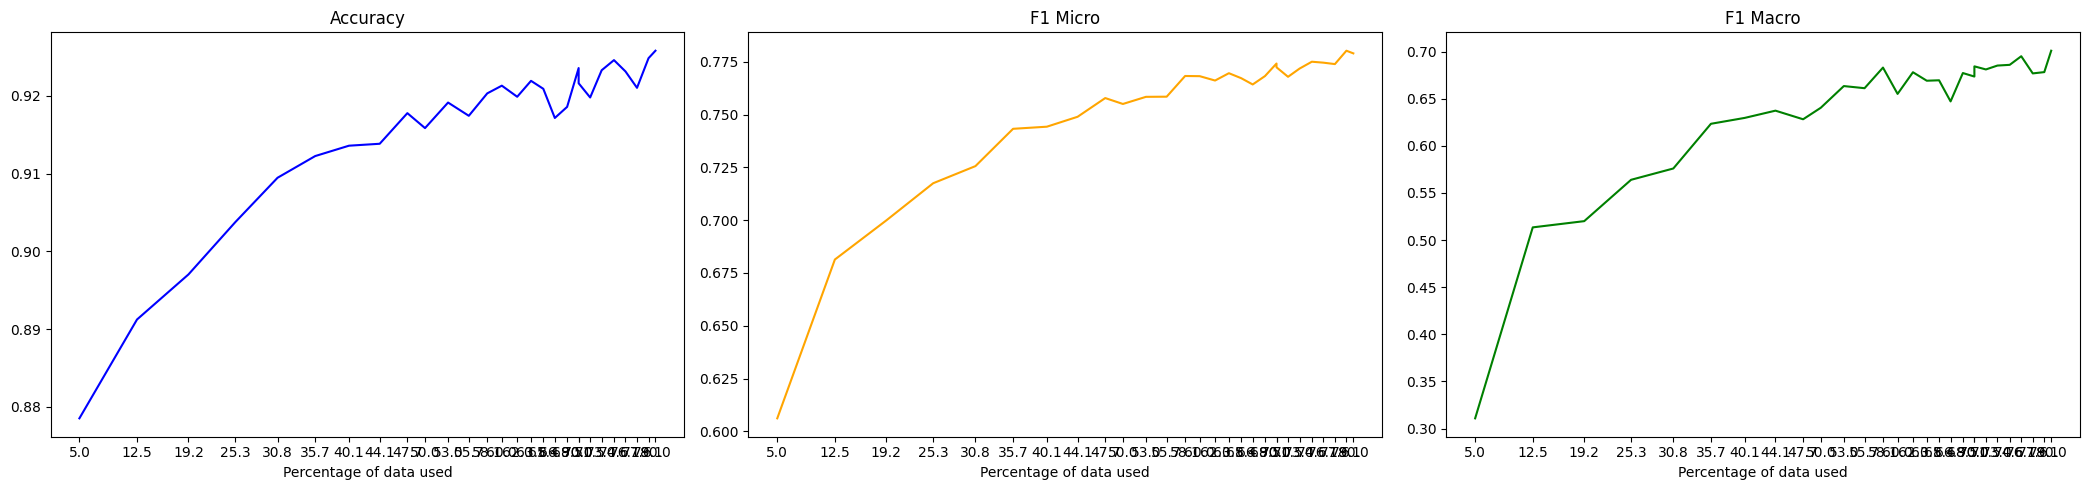

In [ ]:
active_learning(seeds[4], 4)